# Experimentación - A3TGCN

https://arxiv.org/abs/2006.11583

## 1. Obtención de datos



In [22]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [23]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [24]:
results_save_path = "./results"
name_model = "MPNNLSTM"

In [25]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [26]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados



from utils.trainer import TrainerA3TGCN
from  utils.attention_temporal_gcn import A3TGCN
#from torch_geometric_temporal.nn import TGCN

In [27]:
import utils.attention_temporal_gcn
utils.attention_temporal_gcn= reload(utils.attention_temporal_gcn)
from utils.attention_temporal_gcn import A3TGCN

In [28]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, hidden_size, window=1, dropout=0.5):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        self.hidden_size = hidden_size
        self.window = window 
        super(RecurrentGCN, self).__init__()
        self.recurrent = A3TGCN(periods=self.n_features, out_channels=hidden_size, in_channels=1)
        self.linear = torch.nn.Linear(self.hidden_size, self.n_target)

    def forward(self, x, edge_index, edge_weight):
        h= self.recurrent(x.view(x.shape[0], 1, x.shape[1]), edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h


## Prueba - predicción por tipos

In [29]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [30]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [32]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100

#### Sencilla 

In [34]:


device = torch.device("mps")
model_gt = RecurrentGCN(name_model, n_features, n_nodes, n_target, hidden_size)
trainer_gt = TrainerA3TGCN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================



KeyboardInterrupt: 

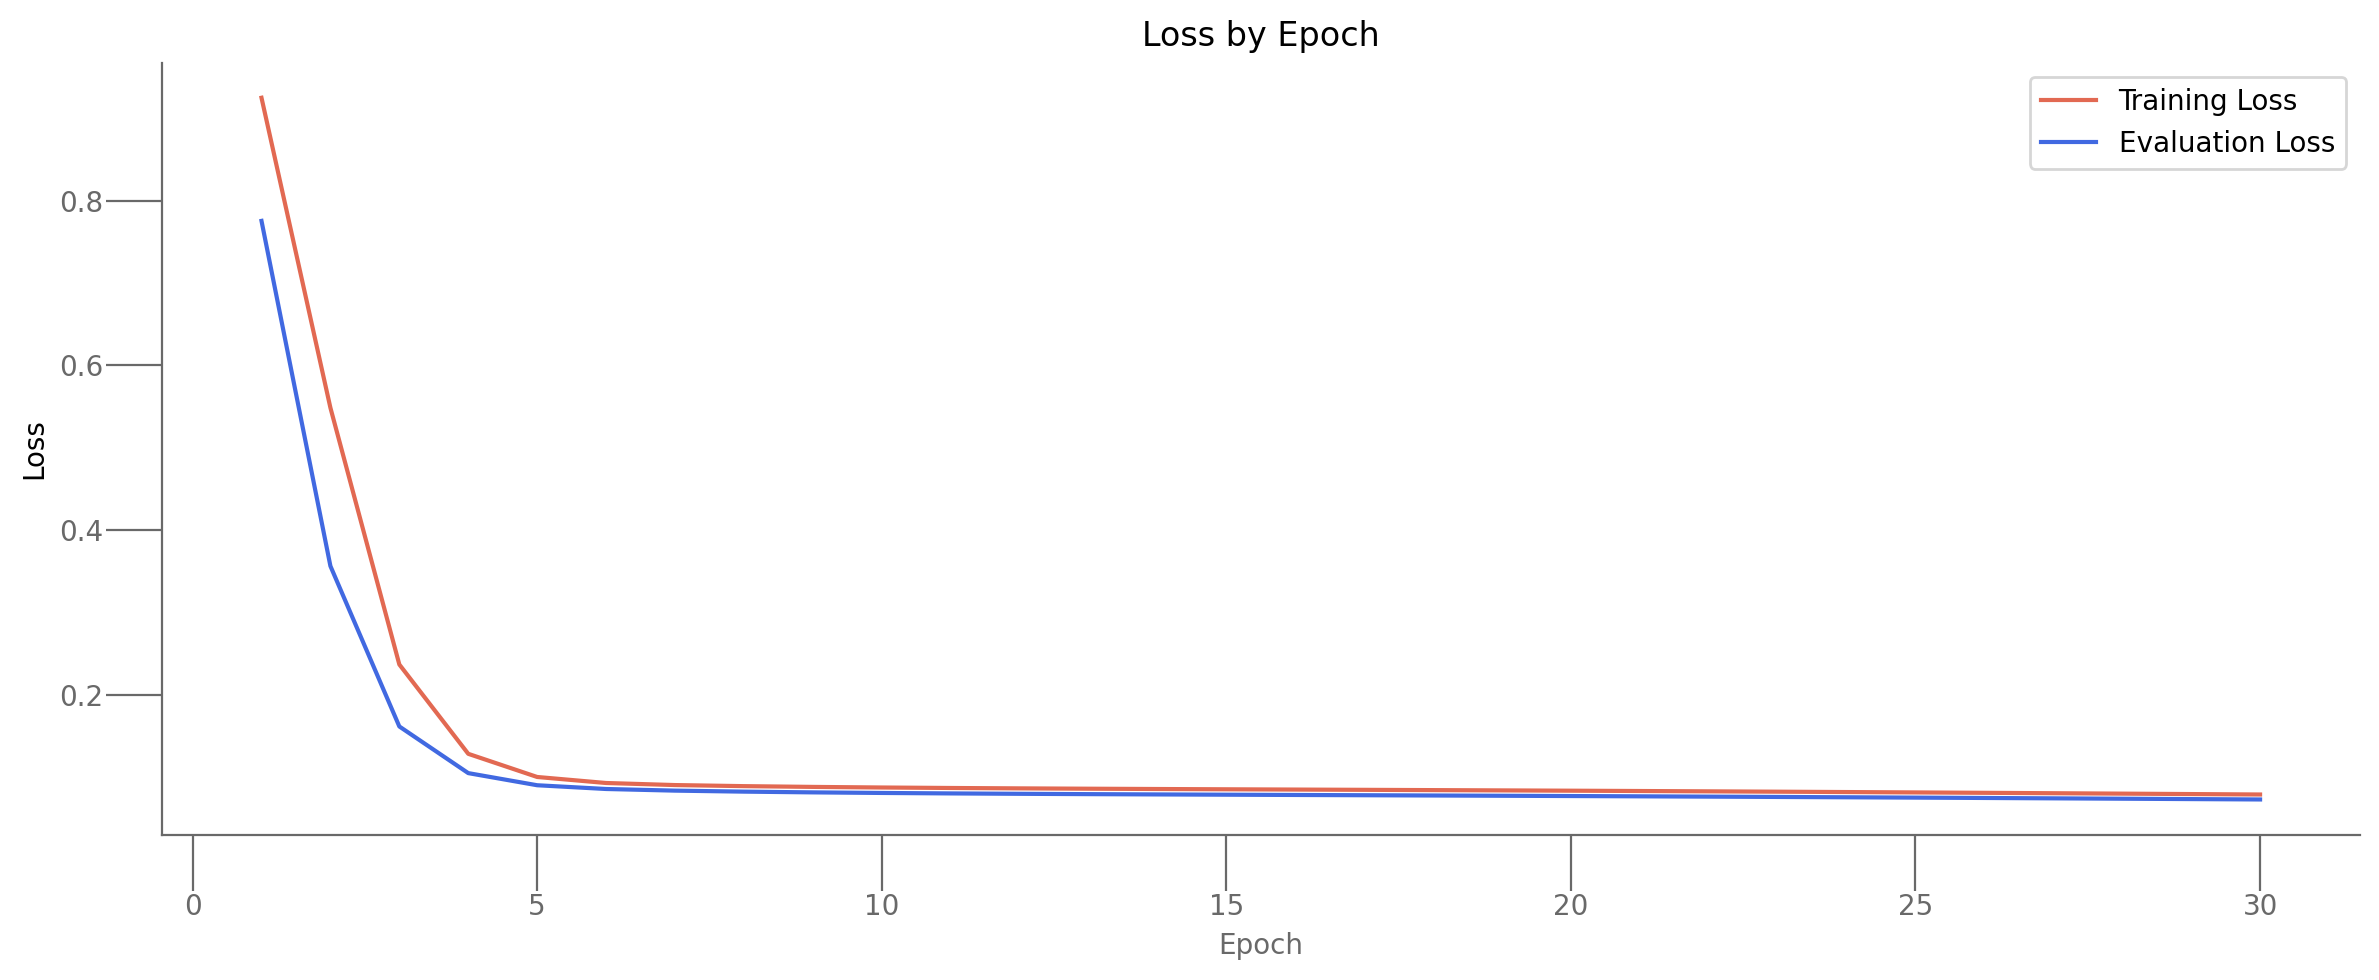


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.058790, test r2score -19.902446


In [20]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()


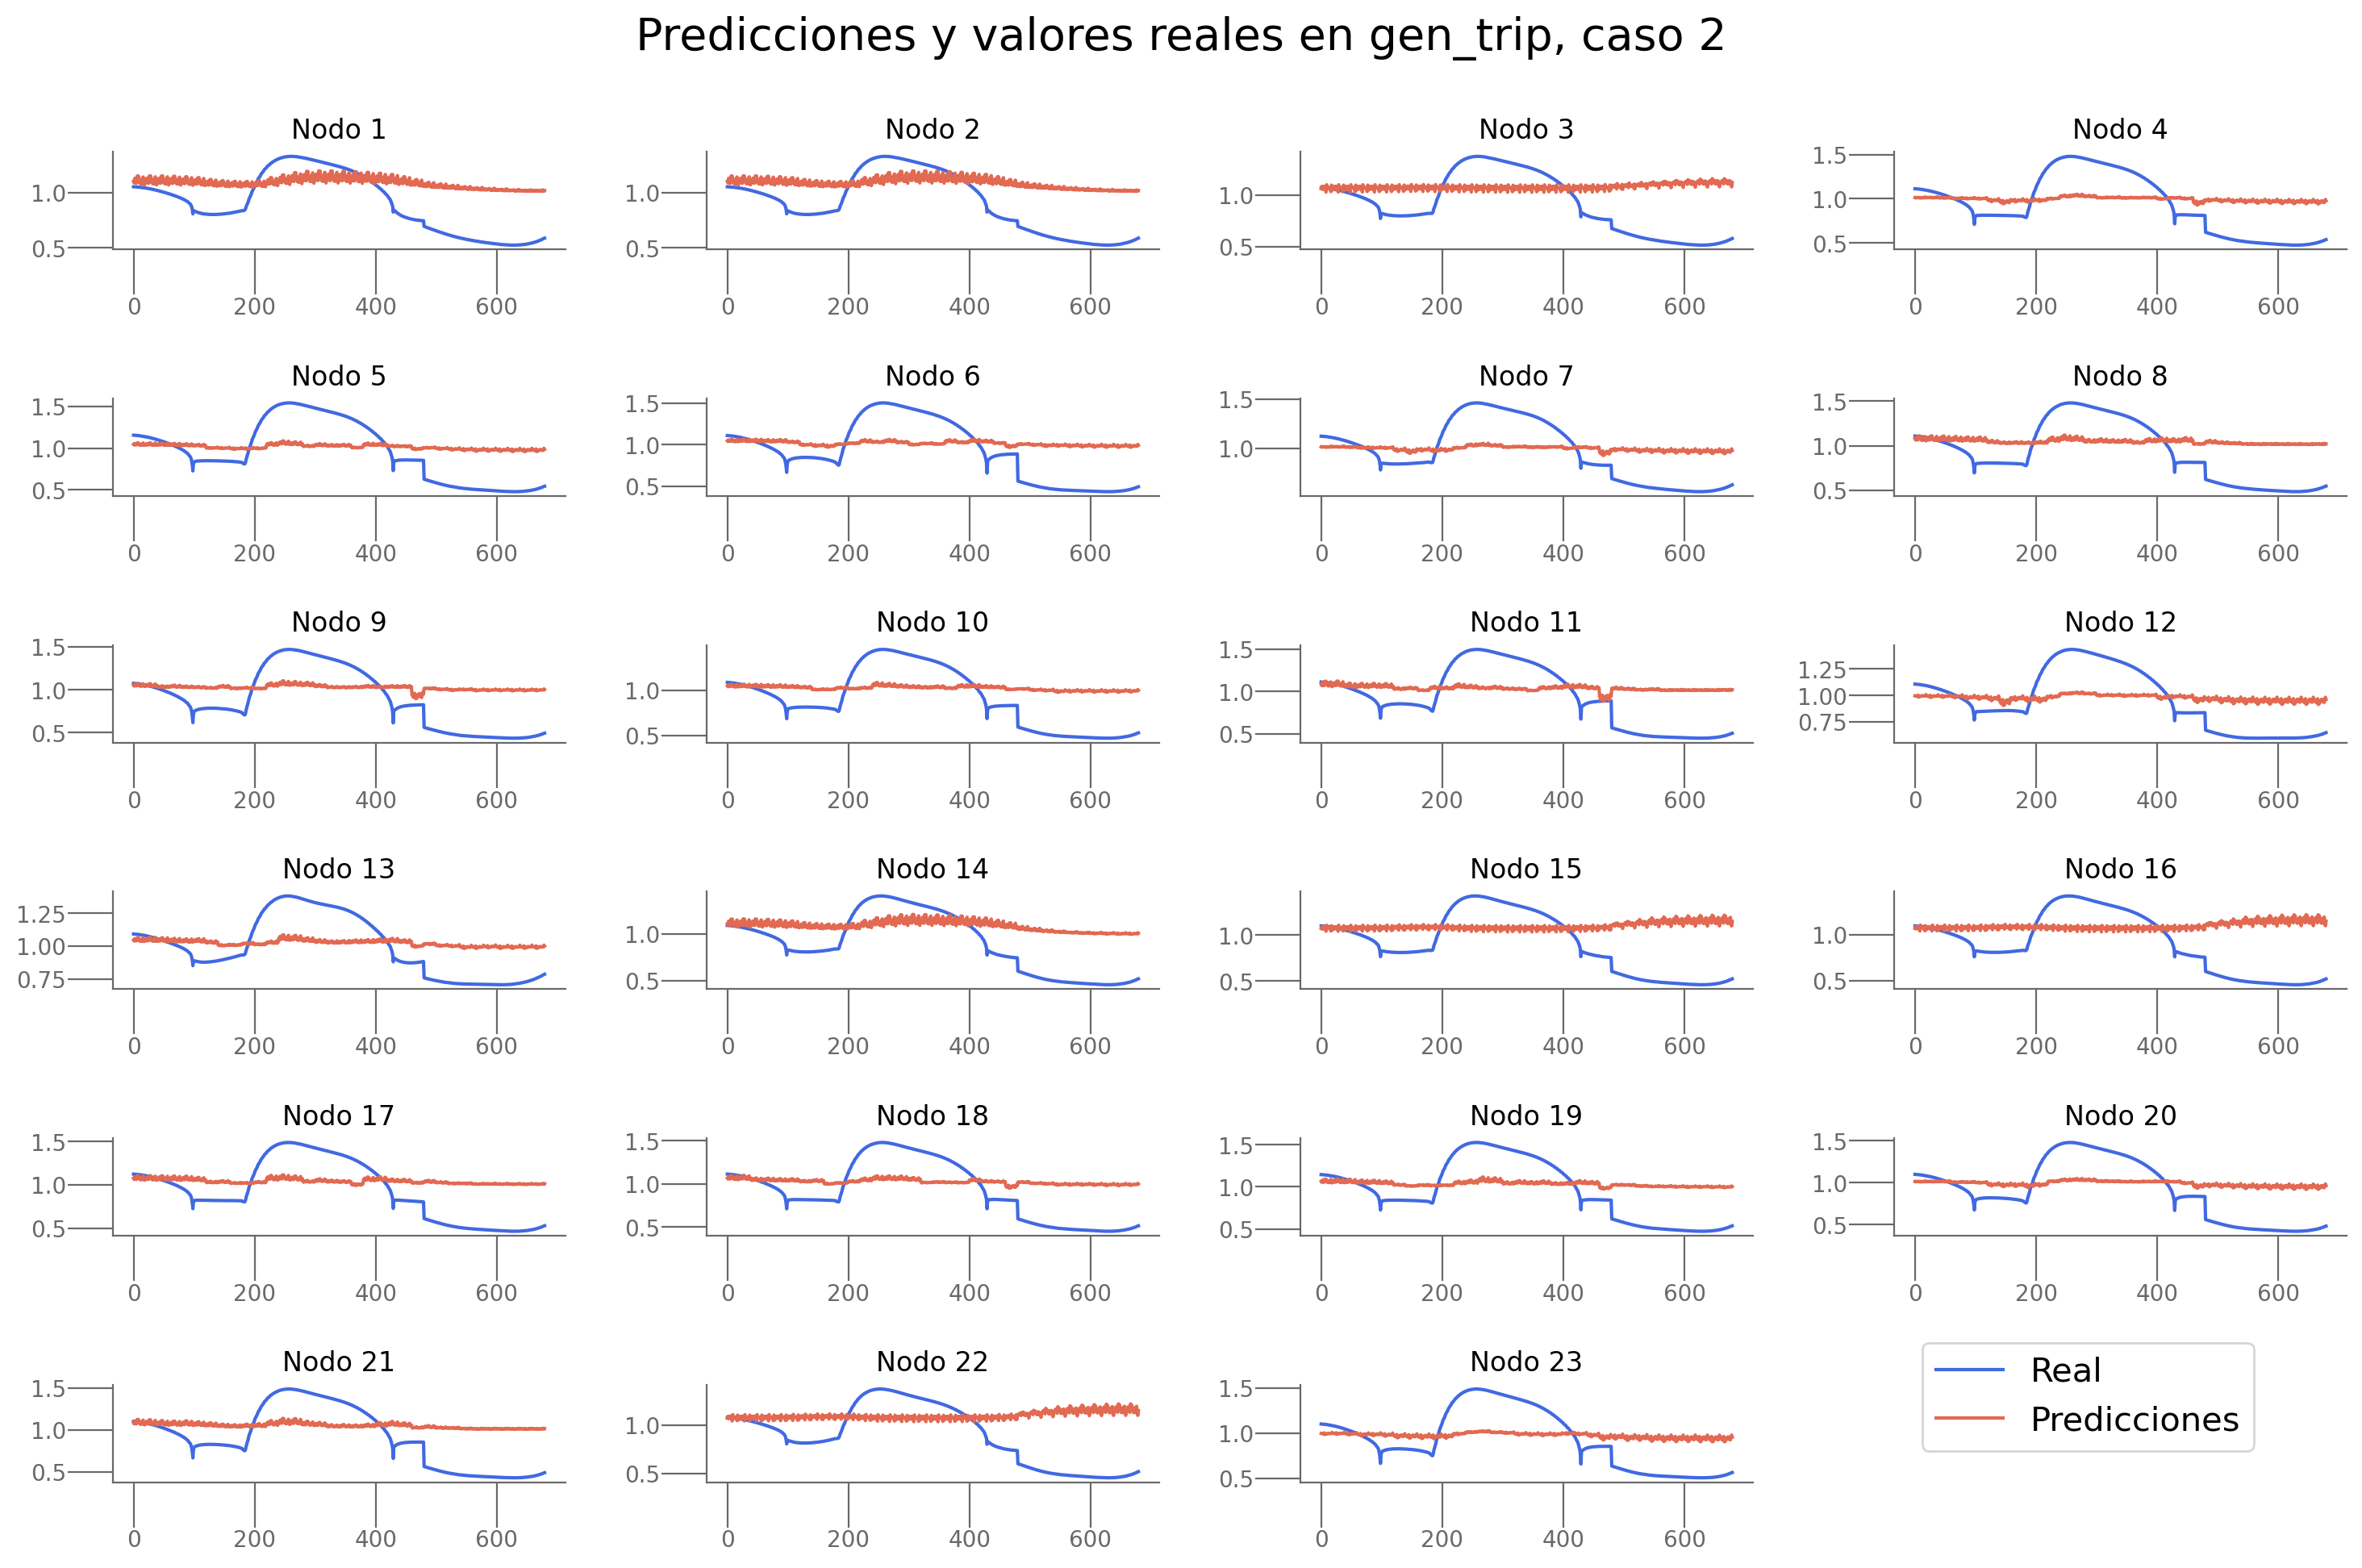

In [21]:
plot_predictions(predictions_gt, real_gt, n_target, 2, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [115]:
param_grid = {
    "hidden_size": [16, 32, 64],
    "dropout": [0.2, 0.5, 0.8]
}

modelo_gt,params_gt, resultados_final_gt, resultados_gt, h = entrenar_y_evaluar_modelos_mpnn_lstm(param_grid, n_features, n_nodes, n_target, dataloader_gt, num_early_stop, num_epochs, lr)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1346 | Eval Loss: 0.2437 | Eval R2: -123.8613 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2432 | Eval Loss: 0.4000 | Eval R2: -231.6969 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.3933 | Eval Loss: 0.5348 | Eval R2: -306.2963 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.5242 | Eval Loss: 0.4205 | Eval R2: -234.5579 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.4131 | Eval Loss: 0.3936 | Eval R2: -218.7589 | LR: 0.001000
Epoch 6/30 | Train Loss: 0.3870 | Eval Loss: 0.3537 | Eval R2: -195.7232 | LR: 0.001000
Epoch 7/30 | Train Loss: 0.3481 | Eval Loss: 0.3075 | Eval R2: -169.2290 | LR: 0.001000
Epoch 8/30 | Train Loss: 0.3032 | Eval Loss: 0.2600 | Eval R2: -141.9396 | LR: 0.001000
Epoch 9/30 | Train Loss: 0.2569 | Eval Loss: 0.2144 | Eval R2: -115.7483 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.2125 | Eval Loss: 0.1732 | Eval R2: -91.9724 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.1725 | Eval Loss: 0.1379 | Eval R2: -7

 11%|█         | 1/9 [44:19<5:54:36, 2659.54s/it]

Test_loss:0.0459, Test_r2:-18.2476
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'loss_final': 0.059339359402656555, 'r2_eval_final': -16.74396383319979, 'loss_eval_final': 0.05281999944383779, 'r2_test': -18.247557962578973, 'loss_test': 0.045888711324390694, 'loss_nodes': [0.04005108401179314, 0.03960233926773071, 0.04245578497648239, 0.05000418797135353, 0.05457543954253197, 0.05410129576921463, 0.04520959034562111, 0.050709161907434464, 0.053248900920152664, 0.04801873117685318, 0.05347105860710144, 0.04706619307398796, 0.0329555980861187, 0.04058605059981346, 0.04236998036503792, 0.04229291155934334, 0.048861924558877945, 0.04811285063624382, 0.0527091920375824, 0.04839203506708145, 0.04876969754695892, 0.03715735301375389, 0.034719016402959824]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.3311 | Eval Loss: 0.3376 | Eval R2: -167.2742 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.3353 | Eval Loss: 0.3535 | Eval R2: -201.8154 

 22%|██▏       | 2/9 [1:28:47<5:10:49, 2664.27s/it]

Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'loss_final': 0.06413242965936661, 'r2_eval_final': -19.268094334912664, 'loss_eval_final': 0.05962369839200169, 'r2_test': -21.074888177538668, 'loss_test': 0.05222091164747392, 'loss_nodes': [0.04612398147583008, 0.045635886490345, 0.04870729148387909, 0.05668950825929642, 0.06151047721505165, 0.06095130741596222, 0.05161602422595024, 0.05745740979909897, 0.06016351282596588, 0.0545123815536499, 0.0602375790476799, 0.05315402150154114, 0.03855343535542488, 0.046596892178058624, 0.0485057458281517, 0.04841861128807068, 0.055431291460990906, 0.05460915341973305, 0.05951899290084839, 0.05486736446619034, 0.05521240830421448, 0.042913008481264114, 0.03969471901655197]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.4442 | Eval Loss: 0.2587 | Eval R2: -128.4083 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2592 | Eval Loss: 0.3701 | Eval R2: -214.2966 | LR: 0.010000
Epoch 3/30 | Train Loss: 

 33%|███▎      | 3/9 [2:12:52<4:25:34, 2655.74s/it]

Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'loss_final': 0.07151132076978683, 'r2_eval_final': -22.933142975979294, 'loss_eval_final': 0.06706408320285219, 'r2_test': -25.639788744422503, 'loss_test': 0.05968188459099114, 'loss_nodes': [0.052659984678030014, 0.05214943736791611, 0.05554809793829918, 0.06437511742115021, 0.06982345879077911, 0.0688423439860344, 0.05916539579629898, 0.06512244045734406, 0.06767886132001877, 0.06190342456102371, 0.06814389675855637, 0.06052844598889351, 0.045558176934719086, 0.053939465433359146, 0.05595899373292923, 0.05586447939276695, 0.06325540691614151, 0.06235359236598015, 0.06766817718744278, 0.06251651048660278, 0.06286345422267914, 0.050105493515729904, 0.04665864631533623]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1745 | Eval Loss: 0.1672 | Eval R2: -84.3774 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1676 | Eval Loss: 0.4430 | Eval R2: -258.5022 | LR: 0.010000
Epoch 3/30 | Train Lo

 44%|████▍     | 4/9 [2:55:07<3:37:20, 2608.15s/it]

Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'loss_final': 0.06089671701192856, 'r2_eval_final': -19.28983257662289, 'loss_eval_final': 0.05599029939721829, 'r2_test': -21.083466331870103, 'loss_test': 0.04880351948550845, 'loss_nodes': [0.04323829710483551, 0.04277472943067551, 0.04561297968029976, 0.053183093667030334, 0.057898156344890594, 0.05701735243201256, 0.04819950833916664, 0.053868722170591354, 0.05628072842955589, 0.050850752741098404, 0.05636042356491089, 0.04976102337241173, 0.03499096259474754, 0.04355679079890251, 0.04539499804377556, 0.045297667384147644, 0.052014973014593124, 0.05115482956171036, 0.05595260486006737, 0.05122232809662819, 0.05149070546030998, 0.040013257414102554, 0.03634600713849068]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1797 | Eval Loss: 0.1977 | Eval R2: -99.8852 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1970 | Eval Loss: 0.3789 | Eval R2: -220.2562 | LR: 0.010000
Epoch 3/30 | Train

 56%|█████▌    | 5/9 [3:36:56<2:51:28, 2572.19s/it]

Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'loss_final': 0.06460060179233551, 'r2_eval_final': -19.857736440667725, 'loss_eval_final': 0.059803479631000786, 'r2_test': -22.033685408506802, 'loss_test': 0.05247809132066755, 'loss_nodes': [0.04538840427994728, 0.04492497816681862, 0.048178836703300476, 0.056673601269721985, 0.062038227915763855, 0.06093430519104004, 0.052089300006628036, 0.05731464922428131, 0.059462450444698334, 0.054364755749702454, 0.06035974994301796, 0.05335164815187454, 0.040101058781147, 0.04727226123213768, 0.0491219237446785, 0.049035076051950455, 0.05583139508962631, 0.054995182901620865, 0.06000453978776932, 0.055122558027505875, 0.055493537336587906, 0.04384059086441994, 0.04109695181250572]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.4422 | Eval Loss: 0.2819 | Eval R2: -141.7655 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2809 | Eval Loss: 0.3535 | Eval R2: -204.7206 | LR: 0.010000
Epoch 3/30 | Tr

 67%|██████▋   | 6/9 [4:22:24<2:11:15, 2625.11s/it]

Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'loss_final': 0.06867166608572006, 'r2_eval_final': -21.38727758941312, 'loss_eval_final': 0.06493362657655712, 'r2_test': -23.730658056989217, 'loss_test': 0.05742384277624246, 'loss_nodes': [0.050971806049346924, 0.050453200936317444, 0.05372653529047966, 0.06214169040322304, 0.06742522120475769, 0.06624498963356018, 0.05712514370679855, 0.06288108229637146, 0.06525149941444397, 0.05960780382156372, 0.06555551290512085, 0.058081842958927155, 0.043594054877758026, 0.05175933614373207, 0.0537605956196785, 0.053658172488212585, 0.06095137447118759, 0.0600123256444931, 0.06528592109680176, 0.060064516961574554, 0.06033720448613167, 0.04794891178607941, 0.04390982538461685]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.5466 | Eval Loss: 0.2580 | Eval R2: -125.1556 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2564 | Eval Loss: 0.3685 | Eval R2: -214.9168 | LR: 0.010000
Epoch 3/30 | Train L

 78%|███████▊  | 7/9 [5:04:55<1:26:41, 2600.90s/it]

Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'loss_final': 0.07134269177913666, 'r2_eval_final': -22.878516178369914, 'loss_eval_final': 0.06728489242984803, 'r2_test': -25.699249139095198, 'loss_test': 0.05995481872076916, 'loss_nodes': [0.05259605124592781, 0.052092183381319046, 0.05553440377116203, 0.06451107561588287, 0.0701817199587822, 0.06895554810762405, 0.05958837643265724, 0.06519844383001328, 0.06747262924909592, 0.06199856474995613, 0.06833157688379288, 0.060766302049160004, 0.04662474989891052, 0.054391346871852875, 0.056371044367551804, 0.056274283677339554, 0.06355344504117966, 0.06264165043830872, 0.0680060014128685, 0.06274238973855972, 0.06309816241264343, 0.05070927366614342, 0.04732184857130051]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.2170 | Eval Loss: 0.1593 | Eval R2: -76.7107 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1618 | Eval Loss: 0.4310 | Eval R2: -251.6436 | LR: 0.010000
Epoch 3/30 | Train Lo

 89%|████████▉ | 8/9 [5:47:17<43:02, 2582.34s/it]  

Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'loss_final': 0.06585948914289474, 'r2_eval_final': -20.02512590350287, 'loss_eval_final': 0.06051149735182163, 'r2_test': -22.161282759413027, 'loss_test': 0.053539144713135, 'loss_nodes': [0.04790707305073738, 0.047420237213373184, 0.05039568990468979, 0.0581217035651207, 0.06294255703687668, 0.06190590187907219, 0.053188733756542206, 0.05884724110364914, 0.06121295318007469, 0.05569515377283096, 0.061217136681079865, 0.05424058437347412, 0.03983854502439499, 0.04804987087845802, 0.04996666684746742, 0.049866627901792526, 0.056852299720048904, 0.05594847351312637, 0.060925230383872986, 0.055988579988479614, 0.05622059851884842, 0.044354695826768875, 0.040293850004673004]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.3025 | Eval Loss: 0.2222 | Eval R2: -110.4768 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2218 | Eval Loss: 0.4126 | Eval R2: -240.2957 | LR: 0.010000
Epoch 3/30 | Train

100%|██████████| 9/9 [6:29:25<00:00, 2596.17s/it]

Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'loss_final': 0.062192440032958984, 'r2_eval_final': -18.588000821052933, 'loss_eval_final': 0.05747282864971547, 'r2_test': -20.208539462365906, 'loss_test': 0.05035309146297799, 'loss_nodes': [0.04485355690121651, 0.044357724487781525, 0.04729725420475006, 0.054979290813207626, 0.05979626998305321, 0.05877571925520897, 0.04993659257888794, 0.055706724524497986, 0.058121323585510254, 0.05252838507294655, 0.058081939816474915, 0.051146816462278366, 0.03633420541882515, 0.04479730874300003, 0.04672406613826752, 0.04662144184112549, 0.0536670945584774, 0.05275396257638931, 0.05776413530111313, 0.052795227617025375, 0.05303472280502319, 0.04107939824461937, 0.03696782886981964]}


In [116]:
losses_tst, r2score_tst, loss_nodes, predictions, real = test(modelo_gt, dataloader_gt)



==================== TEST INFO ===================

Test_loss:0.0459, Test_r2:-18.2476


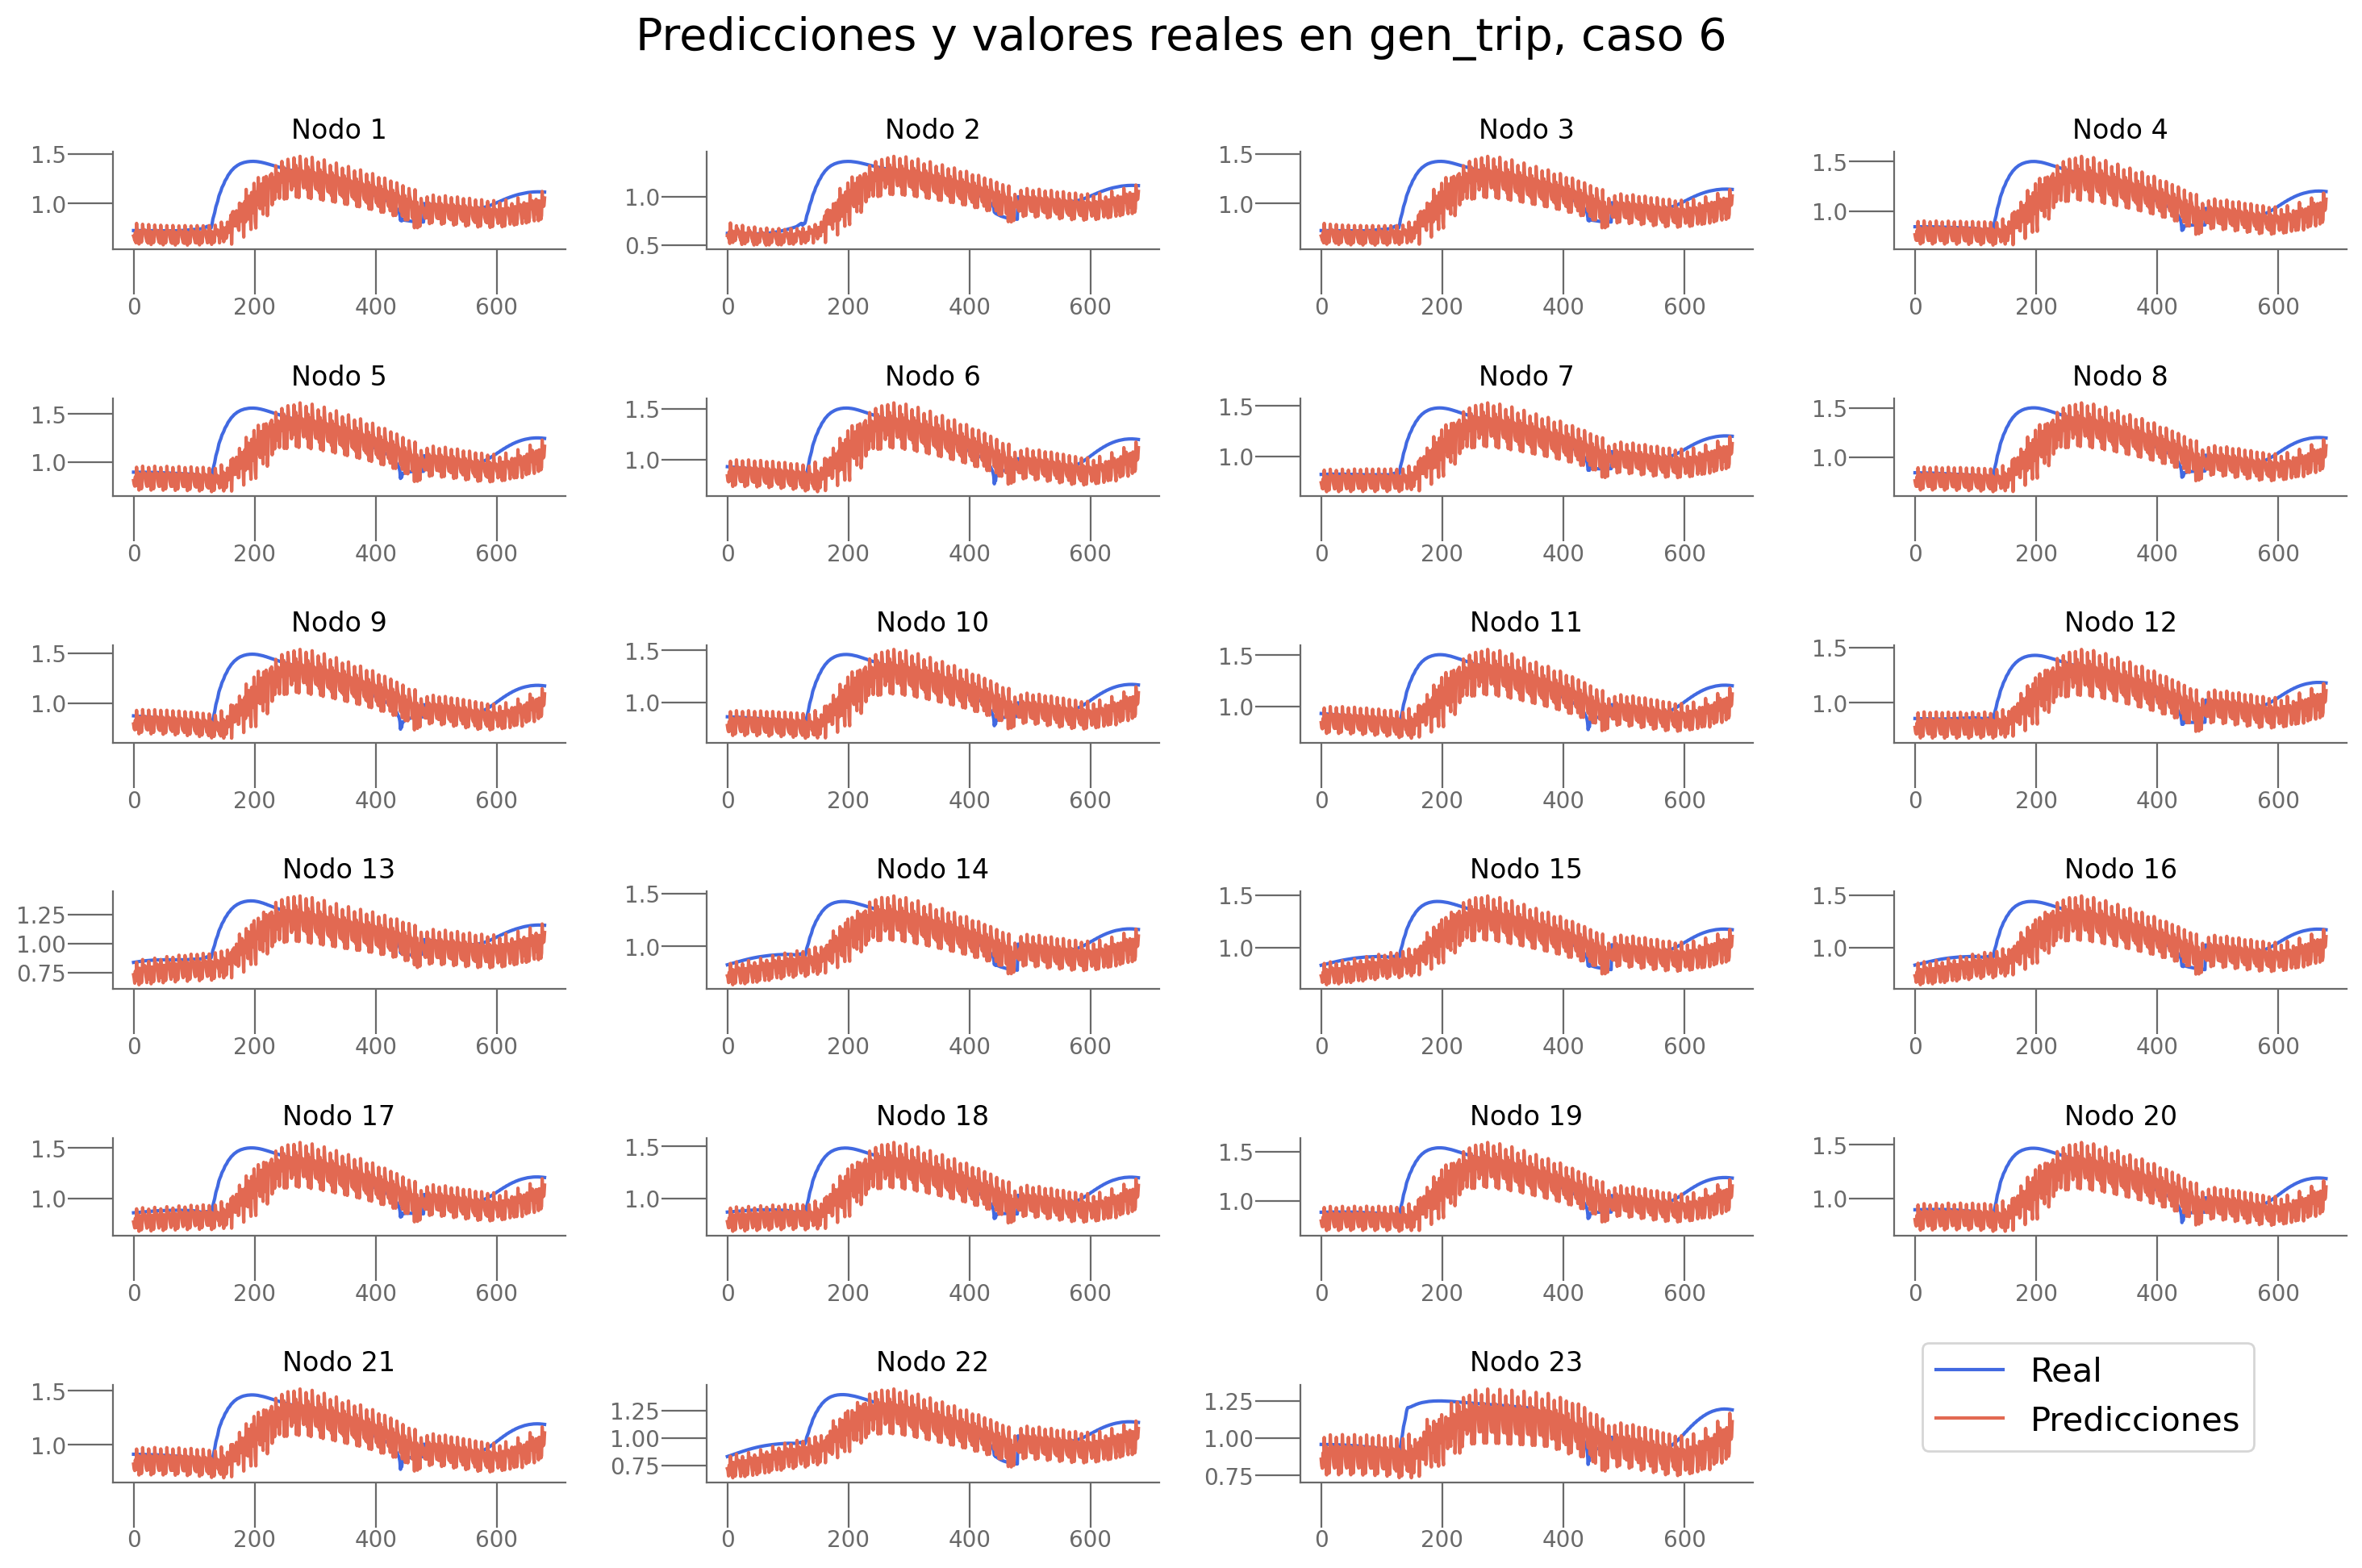

In [121]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [123]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [124]:
guardar_resultados(modelo_gt, "MPNNLSTM", problem_gt, resultados_final_gt, results_save_path, path_save_experiment_gt, params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo          Params  \
0          LSTM             NaN   
1  DryGrEncoder  ('mean', 2, 1)   
2  LSTM_NOBATCH             NaN   
3      MPNNLSTM       (16, 0.2)   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007442   0.358250   
1  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.014867  -5.223569   
2                                                NaN  0.053800 -19.984305   
3    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   

                                          Loss_nodes    R2_eval  Loss_eval  \
0  [0.00292401 0.00315184 0.00446385 0.0074707  0...  -8.137170   0.086898   
1  [0.01353246159851551, 0.01328863762319088, 0.0...  -4.818476   0.019600   
2  [0.23393214 0.05364079 0.05306945 0.05620506 0...   0.000000   0.000000   
3  [0.04005108401179314, 0.03960233926773071, 0.0... -16.74396

### Bus trip

In [125]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [129]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
hidden_size =32
dropout = 0.5

#### Sencilla 

In [142]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_bt = RecurrentGCN("MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=hidden_size, window=1, dropout=dropout)

trainer_bt = TrainerMPNNLSTM(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)
num_early_stop = 0
num_epochs = 30
lr = 0.01

losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()




==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1429 | Eval Loss: 0.0324 | Eval R2: 0.2921 | 
Epoch 2/30 | Train Loss: 0.0273 | Eval Loss: 0.0251 | Eval R2: 0.4668 | 
Epoch 3/30 | Train Loss: 0.0220 | Eval Loss: 0.0213 | Eval R2: 0.5449 | 
Epoch 4/30 | Train Loss: 0.0187 | Eval Loss: 0.0183 | Eval R2: 0.6088 | 
Epoch 5/30 | Train Loss: 0.0161 | Eval Loss: 0.0160 | Eval R2: 0.6577 | 
Epoch 6/30 | Train Loss: 0.0141 | Eval Loss: 0.0143 | Eval R2: 0.6945 | 
Epoch 7/30 | Train Loss: 0.0126 | Eval Loss: 0.0130 | Eval R2: 0.7228 | 
Epoch 8/30 | Train Loss: 0.0115 | Eval Loss: 0.0119 | Eval R2: 0.7446 | 
Epoch 9/30 | Train Loss: 0.0106 | Eval Loss: 0.0111 | Eval R2: 0.7614 | 
Epoch 10/30 | Train Loss: 0.0099 | Eval Loss: 0.0105 | Eval R2: 0.7747 | 
Epoch 11/30 | Train Loss: 0.0093 | Eval Loss: 0.0100 | Eval R2: 0.7855 | 
Epoch 12/30 | Train Los

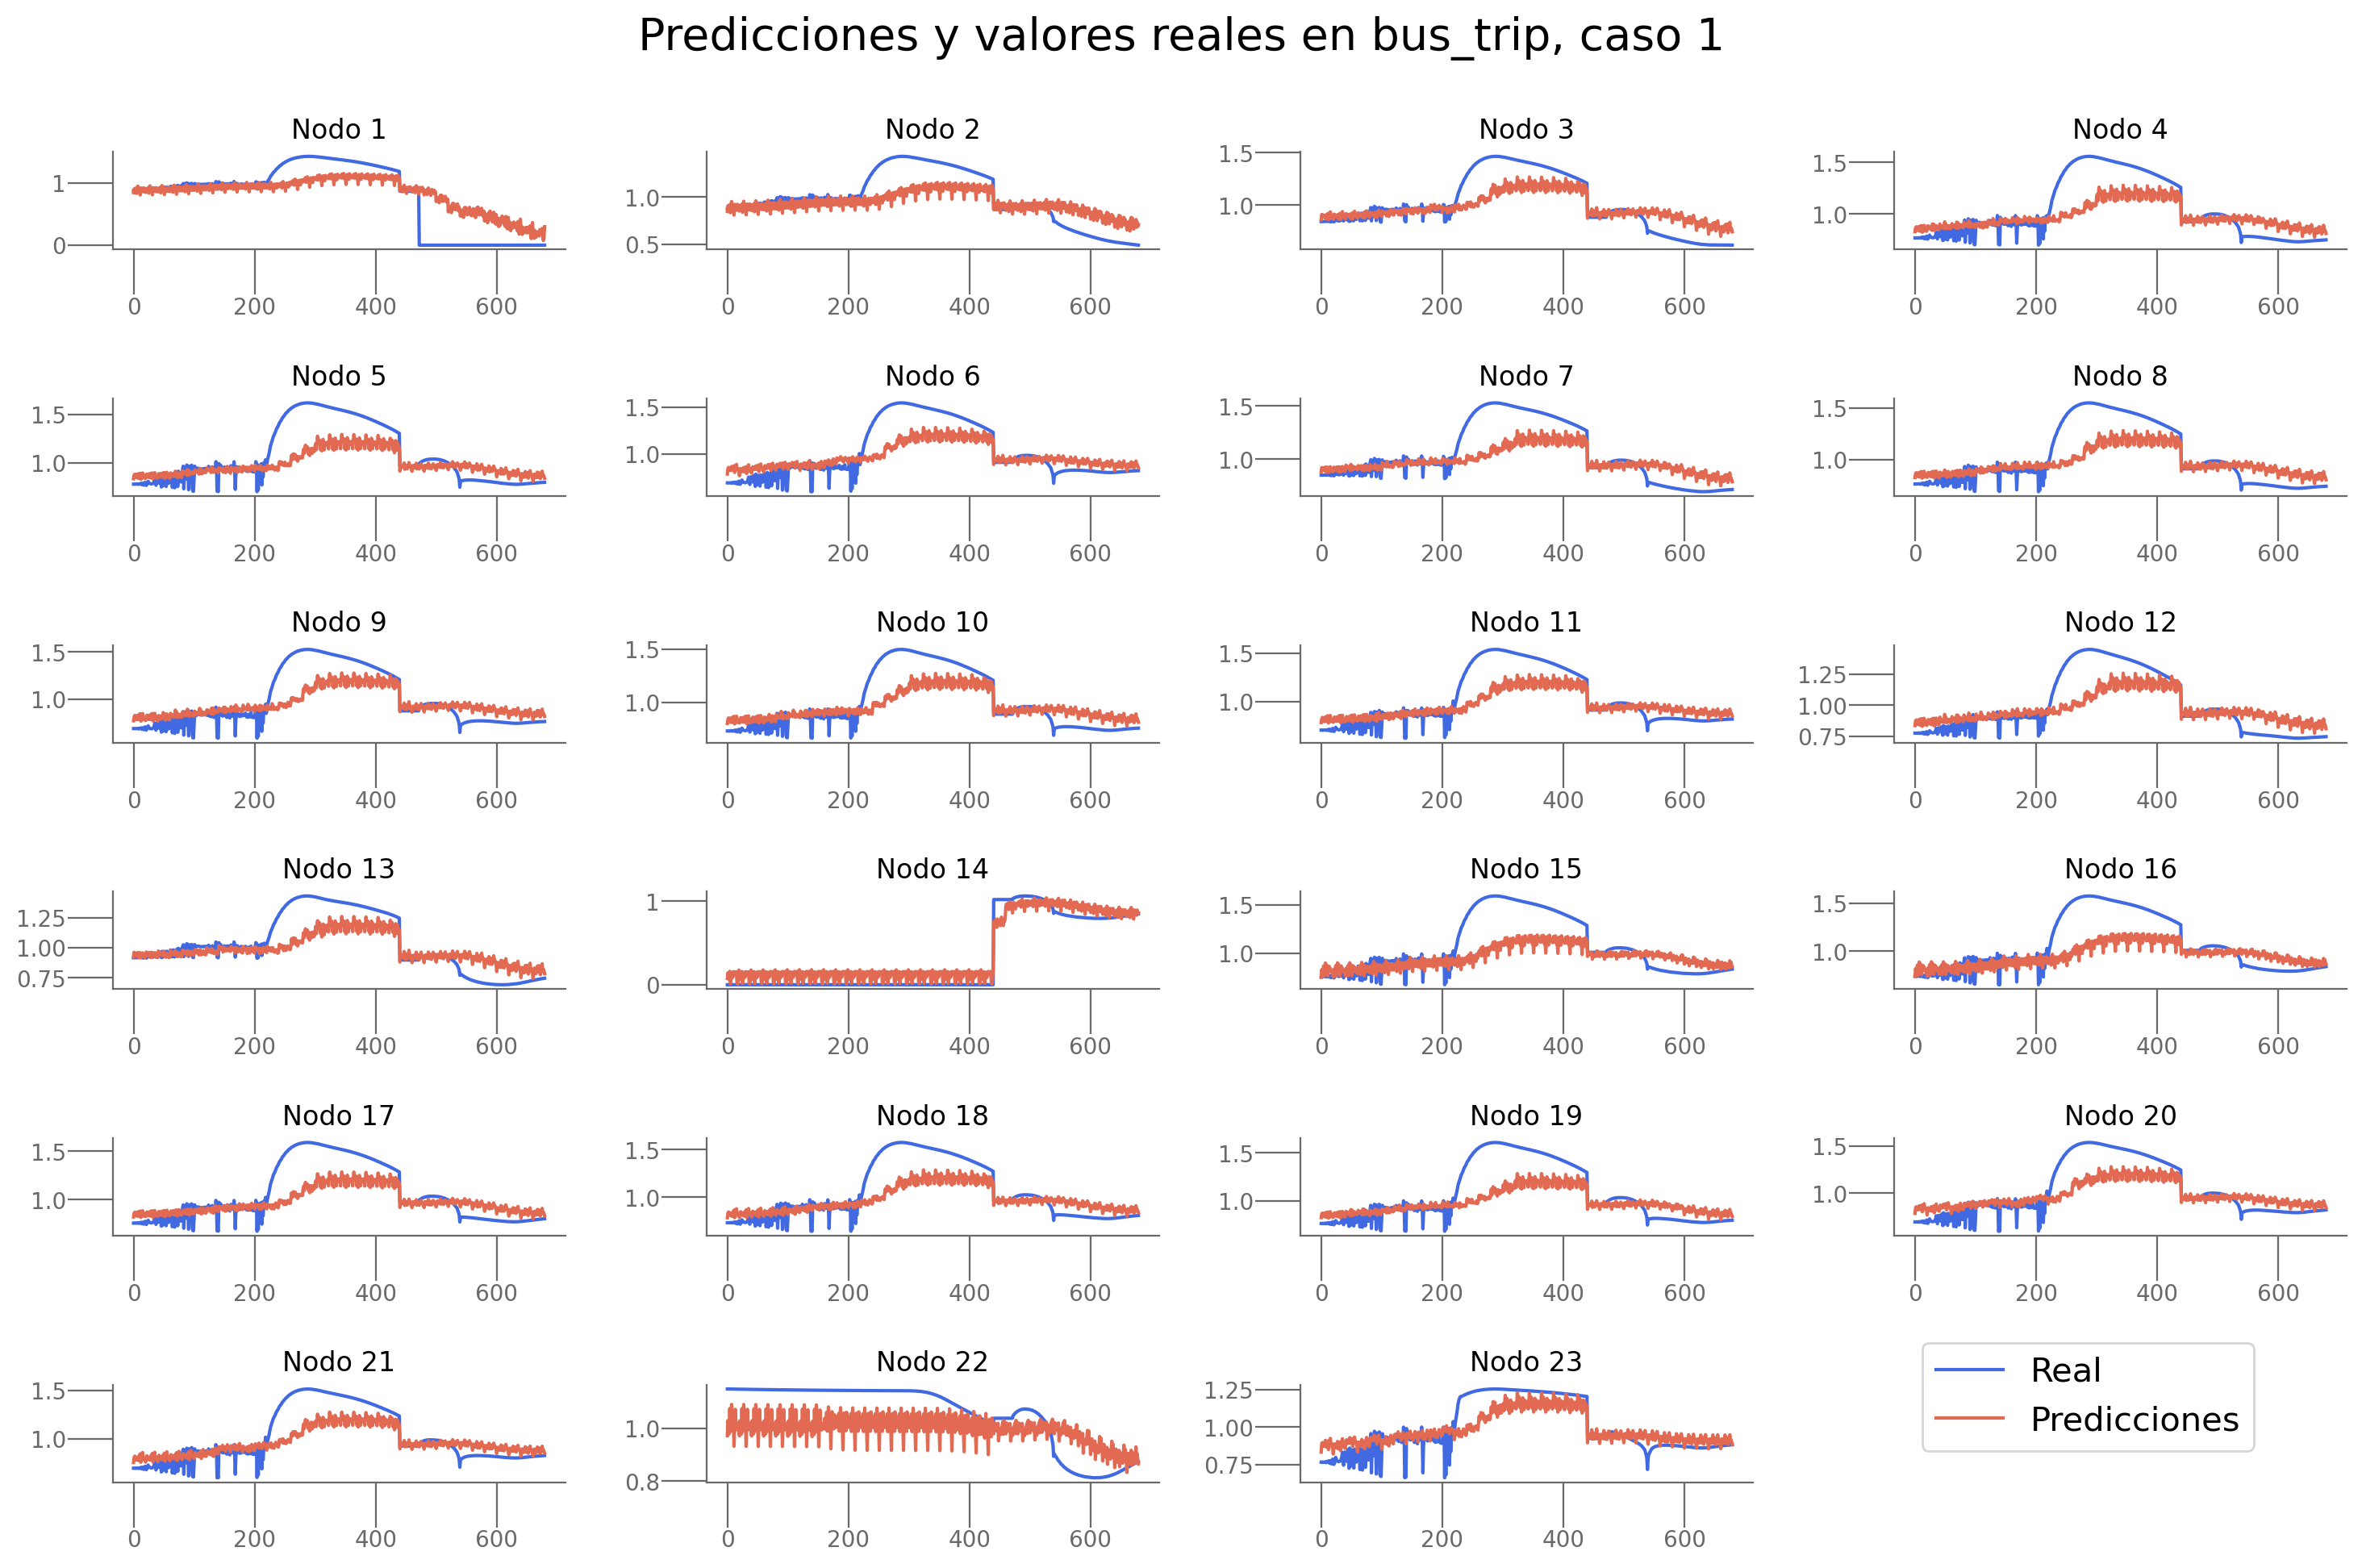

In [54]:
plot_predictions(predictions_bt, real_bt, n_target, 1, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [23]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_bt,params_bt,resultados_final_bt, resultados_bt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_bt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0742 | Eval Loss: 0.3988 | Eval R2: -12.1772 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4033 | Eval Loss: 0.1891 | Eval R2: -5.6730 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1935 | Eval Loss: 0.1539 | Eval R2: -4.5235 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1603 | Eval Loss: 0.0819 | Eval R2: -1.5523 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0871 | Eval Loss: 0.0800 | Eval R2: -1.0695 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0836 | Eval Loss: 0.0996 | Eval R2: -1.5891 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1020 | Eval Loss: 0.0953 | Eval R2: -1.4292 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0970 | Eval Loss: 0.0748 | Eval R2: -0.8094 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0766 | Eval Loss: 0.0591 | Eval R2: -0.4777 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0608 | Eval Loss: 0.0563 | Eval R2: -0.6215 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0578 | Eval Loss: 0.0575 | Eval R2: -0.8117 | LR: 0.0100

 12%|█▎        | 1/8 [06:25<44:56, 385.17s/it]

Test_loss:0.0312, Test_r2:0.1890
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.030043017119169235, 'r2_eval_final': 0.24925290314062662, 'loss_eval_final': 0.029540809904139532, 'r2_test': 0.18898968576568162, 'loss_test': 0.031198040577095694, 'loss_nodes': [0.030855895951390266, 0.03306085243821144, 0.02559652552008629, 0.03495469316840172, 0.03809471055865288, 0.03804665058851242, 0.028537843376398087, 0.04011991620063782, 0.040717653930187225, 0.03233088552951813, 0.03654977306723595, 0.026790250092744827, 0.01657184585928917, 0.02628682553768158, 0.02802109532058239, 0.024961229413747787, 0.036641739308834076, 0.031753454357385635, 0.03893491253256798, 0.033020421862602234, 0.033652156591415405, 0.01726628839969635, 0.02478930726647377]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0235 | Eval Loss: 0.5431 | Eval R2: -16.8607 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5496 | Eval Loss: 0.1242 | Eval R2: -

 25%|██▌       | 2/8 [13:19<40:13, 402.28s/it]

Test_loss:0.0890, Test_r2:-1.2264
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.0895724669098854, 'r2_eval_final': -0.9263420073755723, 'loss_eval_final': 0.08324228962321348, 'r2_test': -1.226390276861722, 'loss_test': 0.08897531923599715, 'loss_nodes': [0.17812494933605194, 0.06370517611503601, 0.056935884058475494, 0.12383344024419785, 0.07019504904747009, 0.07135120034217834, 0.05591868609189987, 0.12813523411750793, 0.0769125372171402, 0.11897437274456024, 0.06870836764574051, 0.05193328857421875, 0.0348014272749424, 0.11144769936800003, 0.10326167941093445, 0.046962130814790726, 0.16693954169750214, 0.05959136039018631, 0.1274961233139038, 0.1402186155319214, 0.06334982067346573, 0.03081992082297802, 0.09681626409292221]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0469 | Eval Loss: 0.6350 | Eval R2: -19.8758 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6570 | Eval Loss: 0.1287 | Eval R2: -2.5105 | LR: 0.

 38%|███▊      | 3/8 [22:55<40:07, 481.57s/it]

Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.027592333033680916, 'r2_eval_final': 0.3119048545175961, 'loss_eval_final': 0.027613044599199603, 'r2_test': 0.28558664034658465, 'loss_test': 0.029372386800580075, 'loss_nodes': [0.033924609422683716, 0.033185701817274094, 0.02014904096722603, 0.03367293253540993, 0.03574095293879509, 0.03396439179778099, 0.02693840116262436, 0.037239786237478256, 0.03693782165646553, 0.02939426526427269, 0.032948512583971024, 0.02447226271033287, 0.016124356538057327, 0.030437316745519638, 0.028319697827100754, 0.02226118929684162, 0.034304678440093994, 0.028066596016287804, 0.038563746958971024, 0.030658701434731483, 0.02889997325837612, 0.01697005145251751, 0.022389959543943405]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0205 | Eval Loss: 0.7332 | Eval R2: -23.8889 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7299 | Eval Loss: 0.1605 | Eval R2: -3.4076 | LR: 0.010000
Epoch 3/3

 50%|█████     | 4/8 [32:53<35:11, 527.79s/it]

Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.020831579342484474, 'r2_eval_final': 0.28734080589259403, 'loss_eval_final': 0.019951658336253, 'r2_test': 0.3274864394887766, 'loss_test': 0.021473132615345857, 'loss_nodes': [0.022424345836043358, 0.0250595360994339, 0.015039521269500256, 0.024278968572616577, 0.025002850219607353, 0.027513286098837852, 0.0186904389411211, 0.02651253342628479, 0.026251692324876785, 0.021154988557100296, 0.022297270596027374, 0.0172655638307333, 0.010524756275117397, 0.021686429157853127, 0.0191186536103487, 0.01501468289643526, 0.027600238099694252, 0.01907418668270111, 0.02715448848903179, 0.026190944015979767, 0.022885063663125038, 0.012121650390326977, 0.02101994678378105]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0633 | Eval Loss: 0.5975 | Eval R2: -19.2646 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5959 | Eval Loss: 0.1377 | Eval R2: -3.7188 | LR: 0.010000
Epoch 3/30 | T

 62%|██████▎   | 5/8 [40:24<25:00, 500.09s/it]

Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.015585387125611305, 'r2_eval_final': 0.599226981030637, 'loss_eval_final': 0.015161787028874045, 'r2_test': 0.5561501007391957, 'loss_test': 0.0162671503497201, 'loss_nodes': [0.012346855364739895, 0.013770419172942638, 0.012597077526152134, 0.01988494209945202, 0.017955200746655464, 0.020045896992087364, 0.015779150649905205, 0.02117941342294216, 0.02230188064277172, 0.016246333718299866, 0.019948158413171768, 0.015271022915840149, 0.008626526221632957, 0.012197485193610191, 0.015216076746582985, 0.011485553346574306, 0.021111998707056046, 0.01633497141301632, 0.021324913948774338, 0.017438845708966255, 0.017729762941598892, 0.009809259325265884, 0.015542750246822834]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0357 | Eval Loss: 0.7963 | Eval R2: -26.2660 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7995 | Eval Loss: 0.2221 | Eval R2: -5.6120 | LR: 0.010000
Epoc

 75%|███████▌  | 6/8 [47:37<15:54, 477.01s/it]

Test_loss:0.0576, Test_r2:-0.5438
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.05503934249281883, 'r2_eval_final': -0.4834560570156455, 'loss_eval_final': 0.05461086552943392, 'r2_test': -0.5438029126837479, 'loss_test': 0.05758446275668089, 'loss_nodes': [0.11827492713928223, 0.0638536736369133, 0.04231627658009529, 0.062354881316423416, 0.06521650403738022, 0.06376441568136215, 0.04731913283467293, 0.06619566679000854, 0.06357239931821823, 0.05779717490077019, 0.06146525964140892, 0.04230993241071701, 0.02985161915421486, 0.07759169489145279, 0.0485256053507328, 0.043169159442186356, 0.0643051266670227, 0.052991658449172974, 0.06839706748723984, 0.05972197651863098, 0.05613178387284279, 0.029428012669086456, 0.039888784289360046]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0665 | Eval Loss: 0.6223 | Eval R2: -20.6222 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6347 | Eval Loss: 0.1350 | Eval R2: -3.2071 

 88%|████████▊ | 7/8 [57:05<08:26, 506.91s/it]

Test_loss:0.0190, Test_r2:0.4699
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.01697964407503605, 'r2_eval_final': 0.476675560512632, 'loss_eval_final': 0.01776549413896583, 'r2_test': 0.46989498337765484, 'loss_test': 0.018997652999526108, 'loss_nodes': [0.014366754330694675, 0.023010438308119774, 0.0140493493527174, 0.021920667961239815, 0.02051793783903122, 0.02482576295733452, 0.017722558230161667, 0.022478438913822174, 0.023536114022135735, 0.017134472727775574, 0.021269097924232483, 0.017553752288222313, 0.008946498855948448, 0.016260948032140732, 0.01831723004579544, 0.014831791631877422, 0.024600420147180557, 0.017601441591978073, 0.02439747378230095, 0.022702544927597046, 0.02026425674557686, 0.011264125816524029, 0.01937398500740528]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9920 | Eval Loss: 0.6586 | Eval R2: -20.9078 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6711 | Eval Loss: 0.1448 | Eval R

100%|██████████| 8/8 [1:07:29<00:00, 506.20s/it]

Test_loss:0.0859, Test_r2:-1.0359
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.087540403008461, 'r2_eval_final': -0.8367694129887238, 'loss_eval_final': 0.08408827620890291, 'r2_test': -1.0359084171268085, 'loss_test': 0.08594639765445229, 'loss_nodes': [0.16147467494010925, 0.05963809788227081, 0.05210496857762337, 0.12116412073373795, 0.0697273463010788, 0.06812240183353424, 0.05437587946653366, 0.12025832384824753, 0.06926310062408447, 0.1167270764708519, 0.06526710093021393, 0.04834779351949692, 0.035018693655729294, 0.10436880588531494, 0.10724905133247375, 0.04780445992946625, 0.16573011875152588, 0.05818170681595802, 0.124314084649086, 0.14377741515636444, 0.06005914509296417, 0.03331075608730316, 0.09048210084438324]}


In [24]:
losses_tst, r2score_tst, loss_nodes_bt, predictions_bt_ajuste, real_bt_ajuste = test(modelo_bt, dataloader_bt, modelo_bt.h)



==================== TEST INFO ===================

Test_loss:0.0163, Test_r2:0.5562


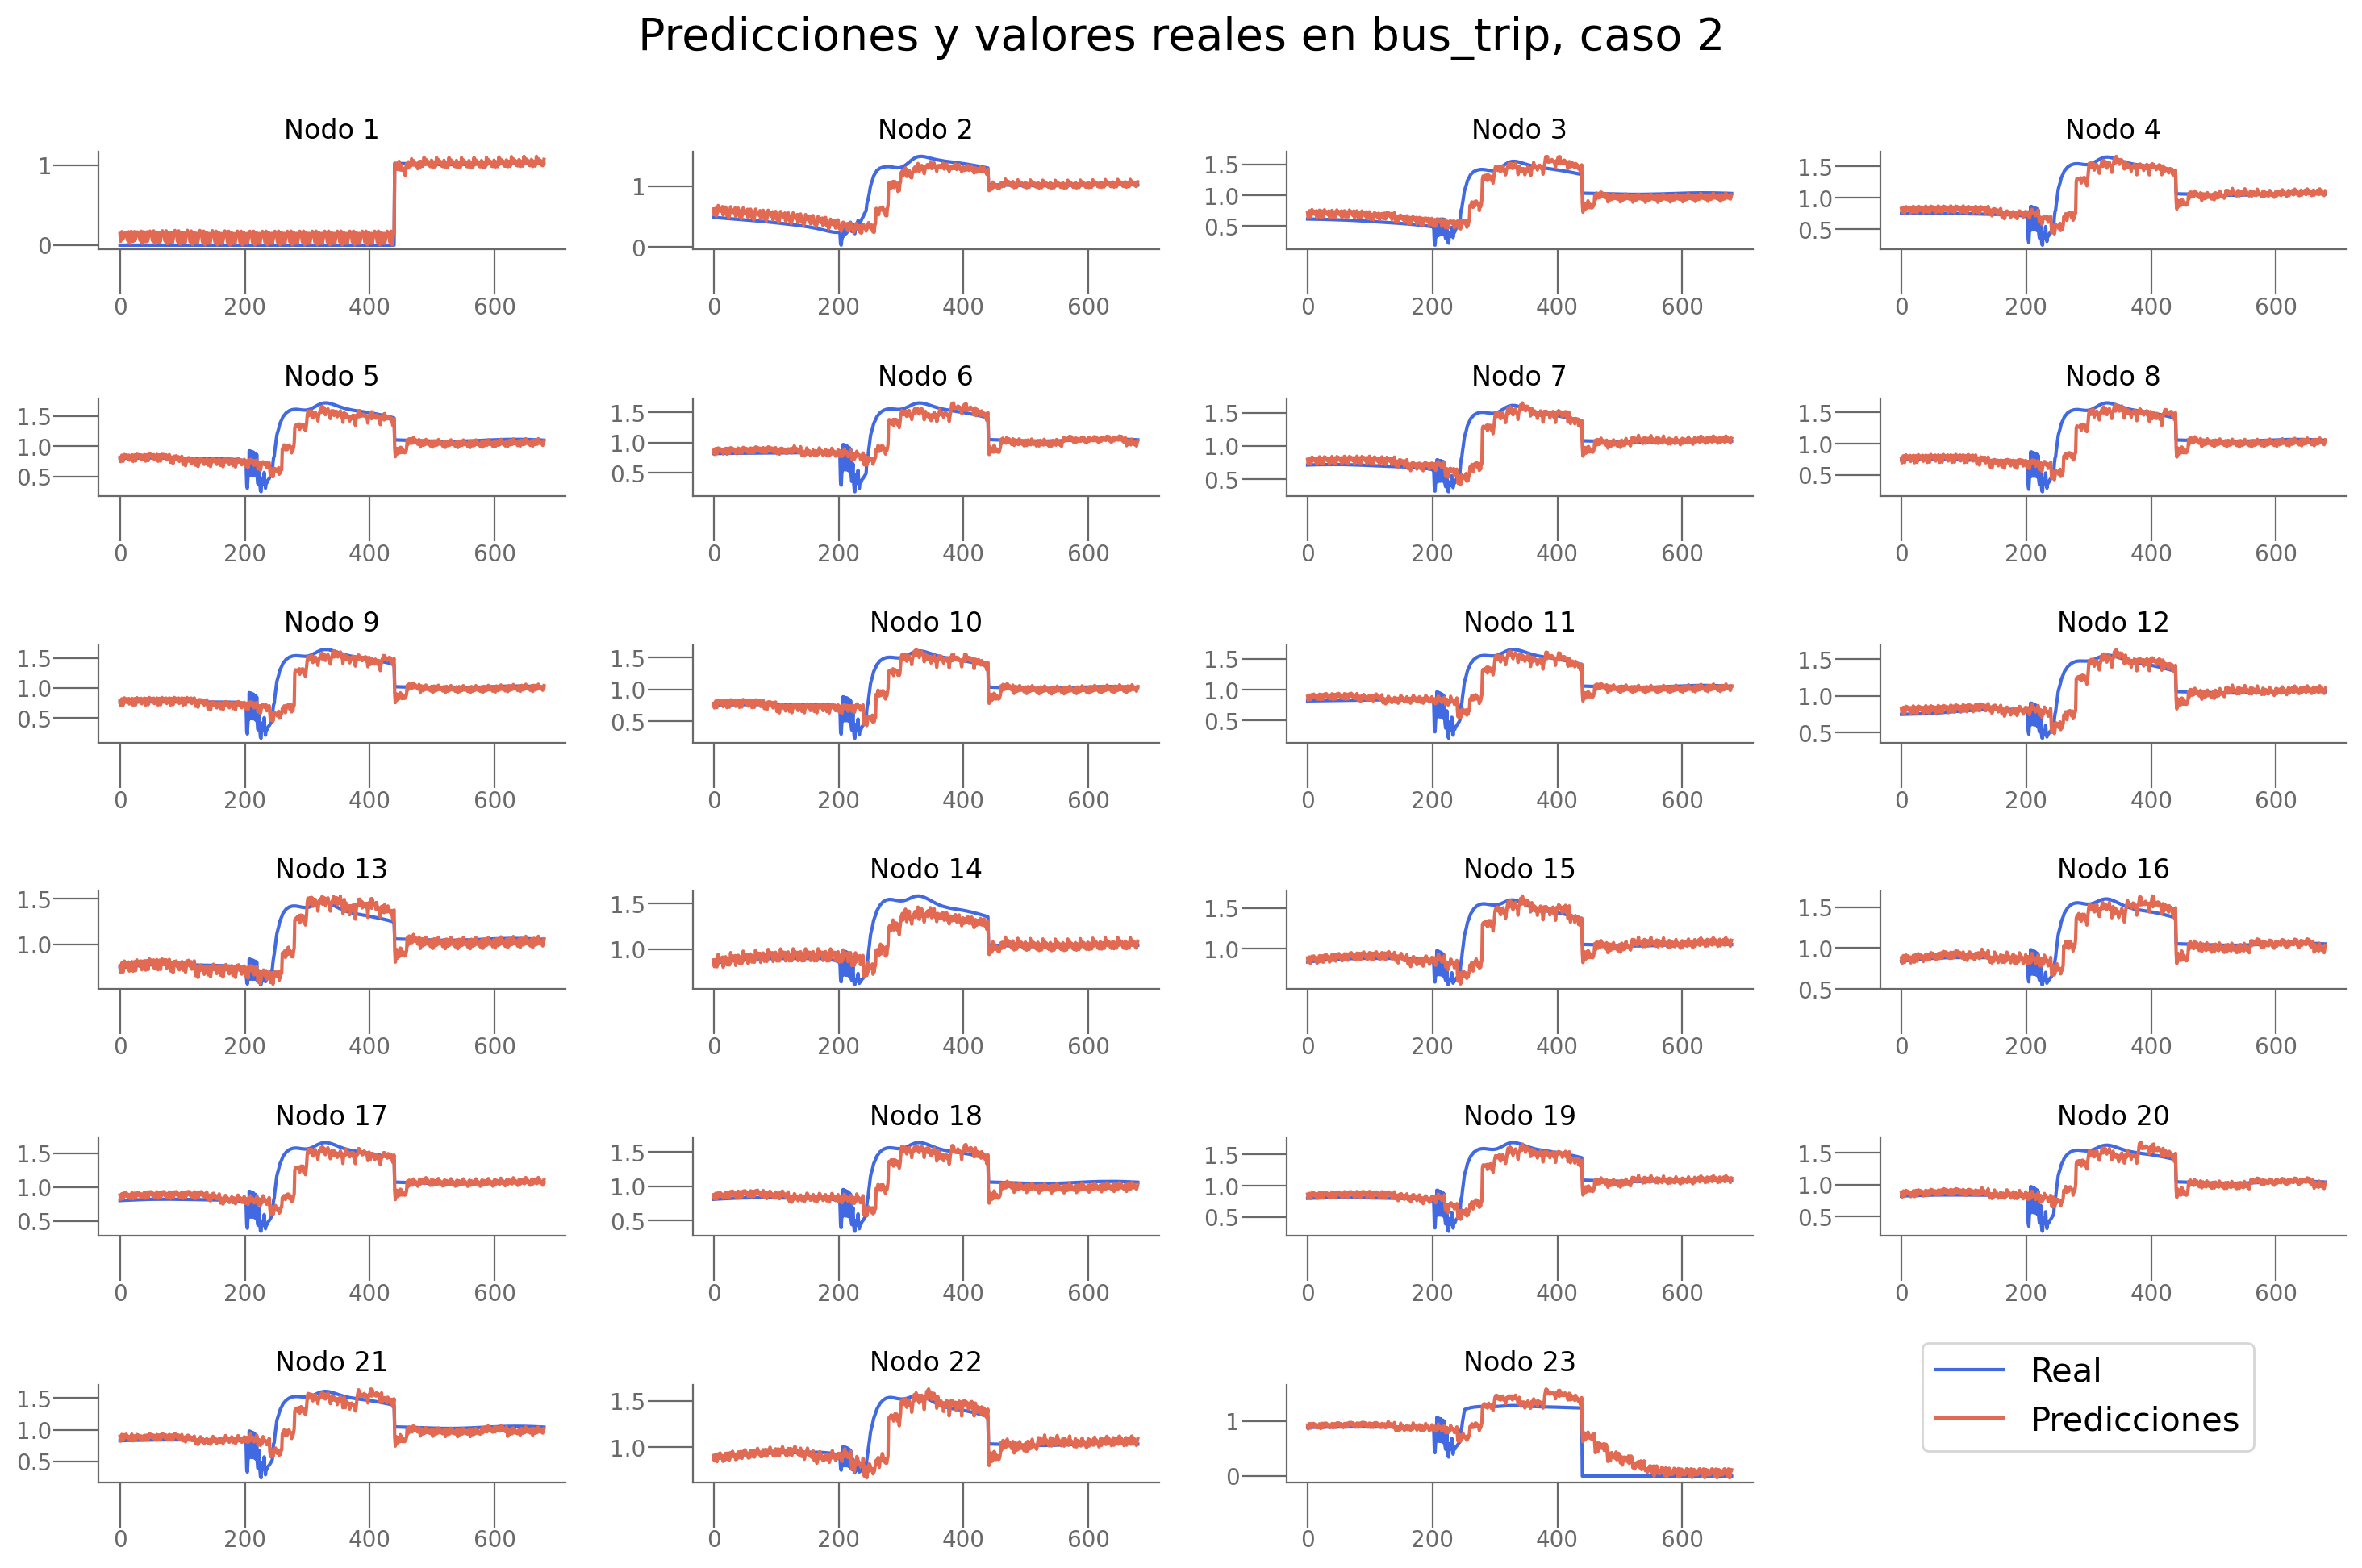

In [28]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 2, n_div_bt, problem_bt)

In [29]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [32]:
guardar_resultados(modelo_bt, "DryGrEncoder", problem_bt, resultados_final_bt, results_save_path, path_save_experiment_bt, params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo        Params  \
0          LSTM           NaN   
1  DryGrEncoder  (mean, 1, 1)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005105  0.924924   
1  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.016267  0.556150   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00321016 0.00406848 0.00364592 0.00553952 0... -1.715052   0.163971   
1  [0.012346855364739895, 0.013770419172942638, 0...  0.599227   0.015162   

   Loss_final  
0    0.004536  
1    0.015585  

==================== RESULTADOS GUARDADOS ===================



### Bus fault

In [34]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [35]:
n_div_bf = loader.div

In [37]:
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5



dataloader_bf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

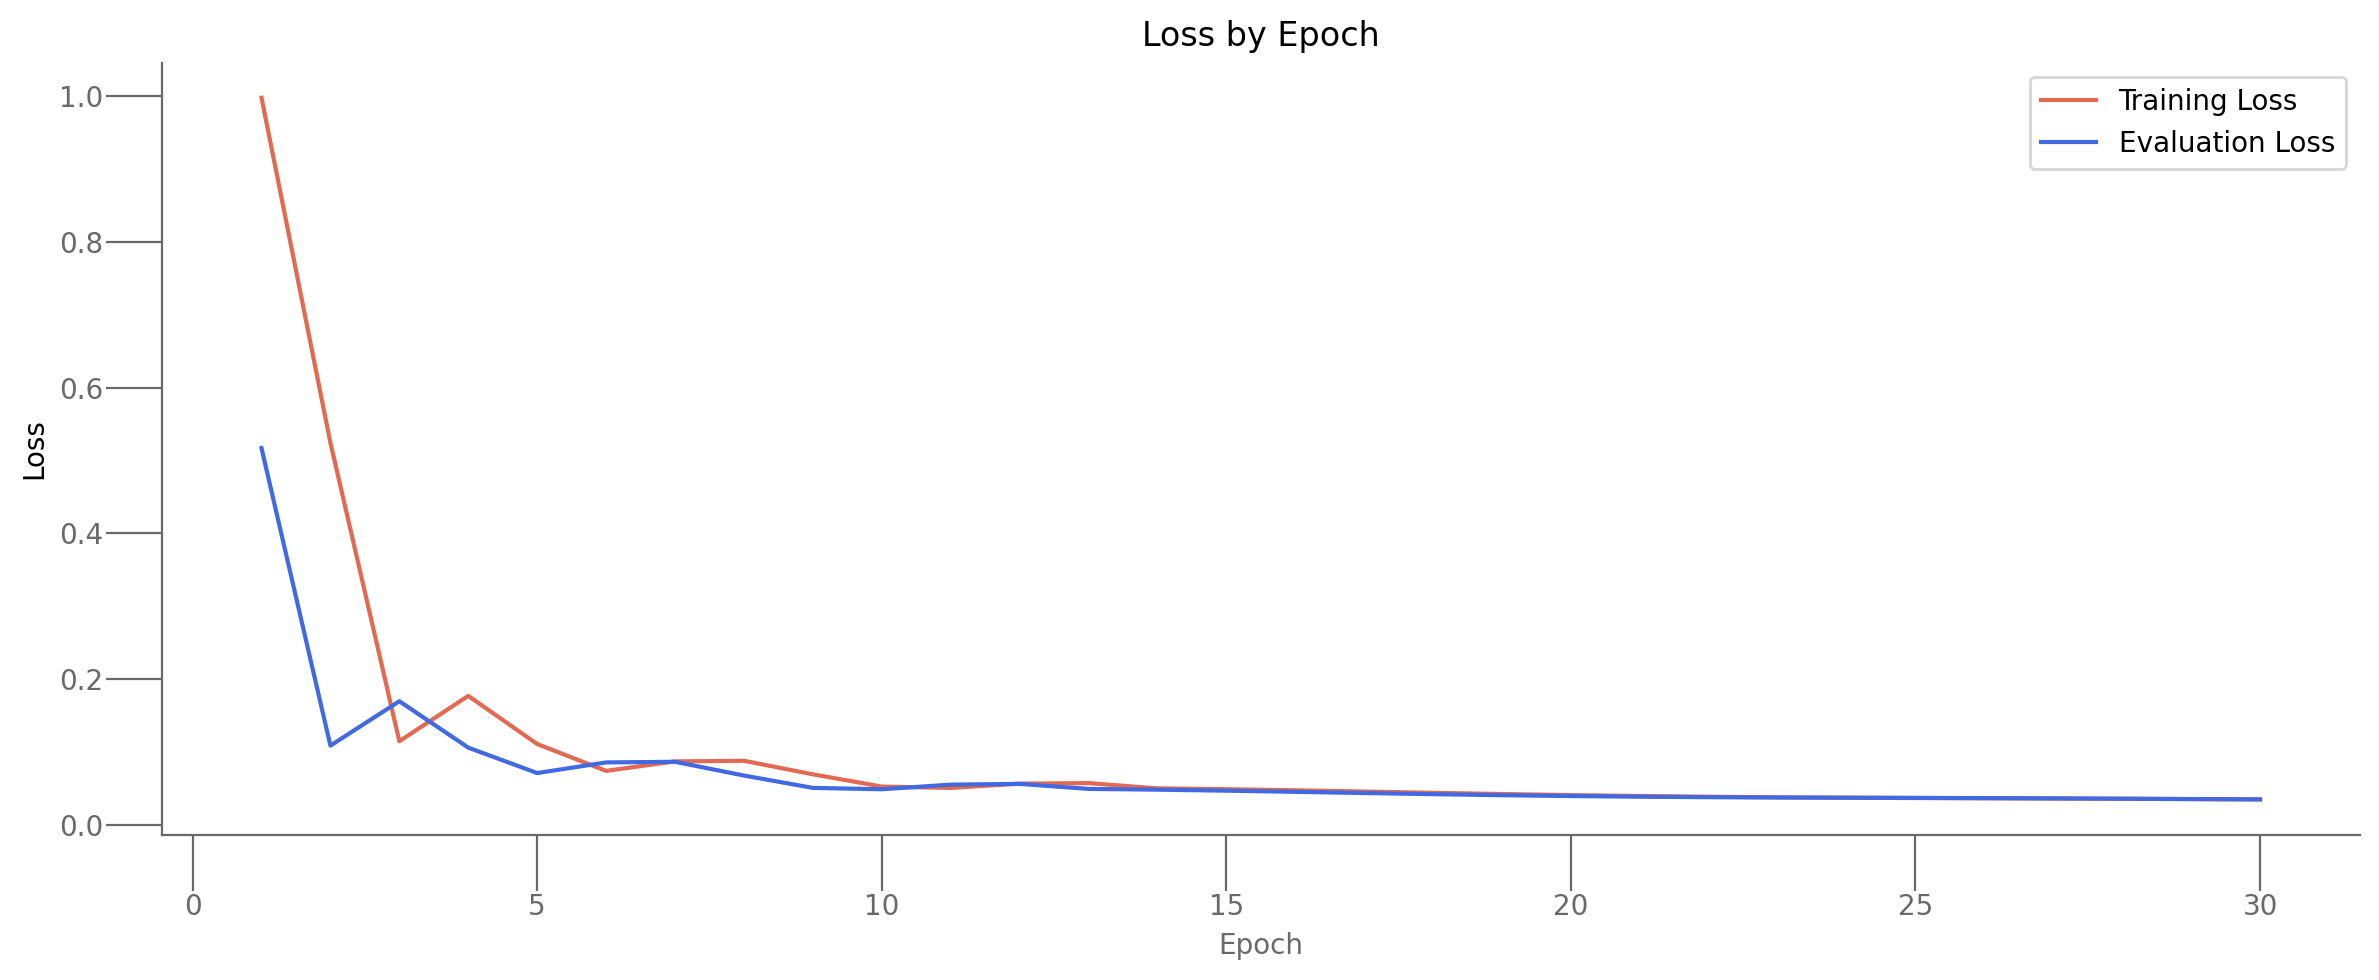


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [58]:

model_bf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_bf, dataloader_bf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_bf, predictions_bf, real_bf = test(model_bf, dataloader_bf, h)


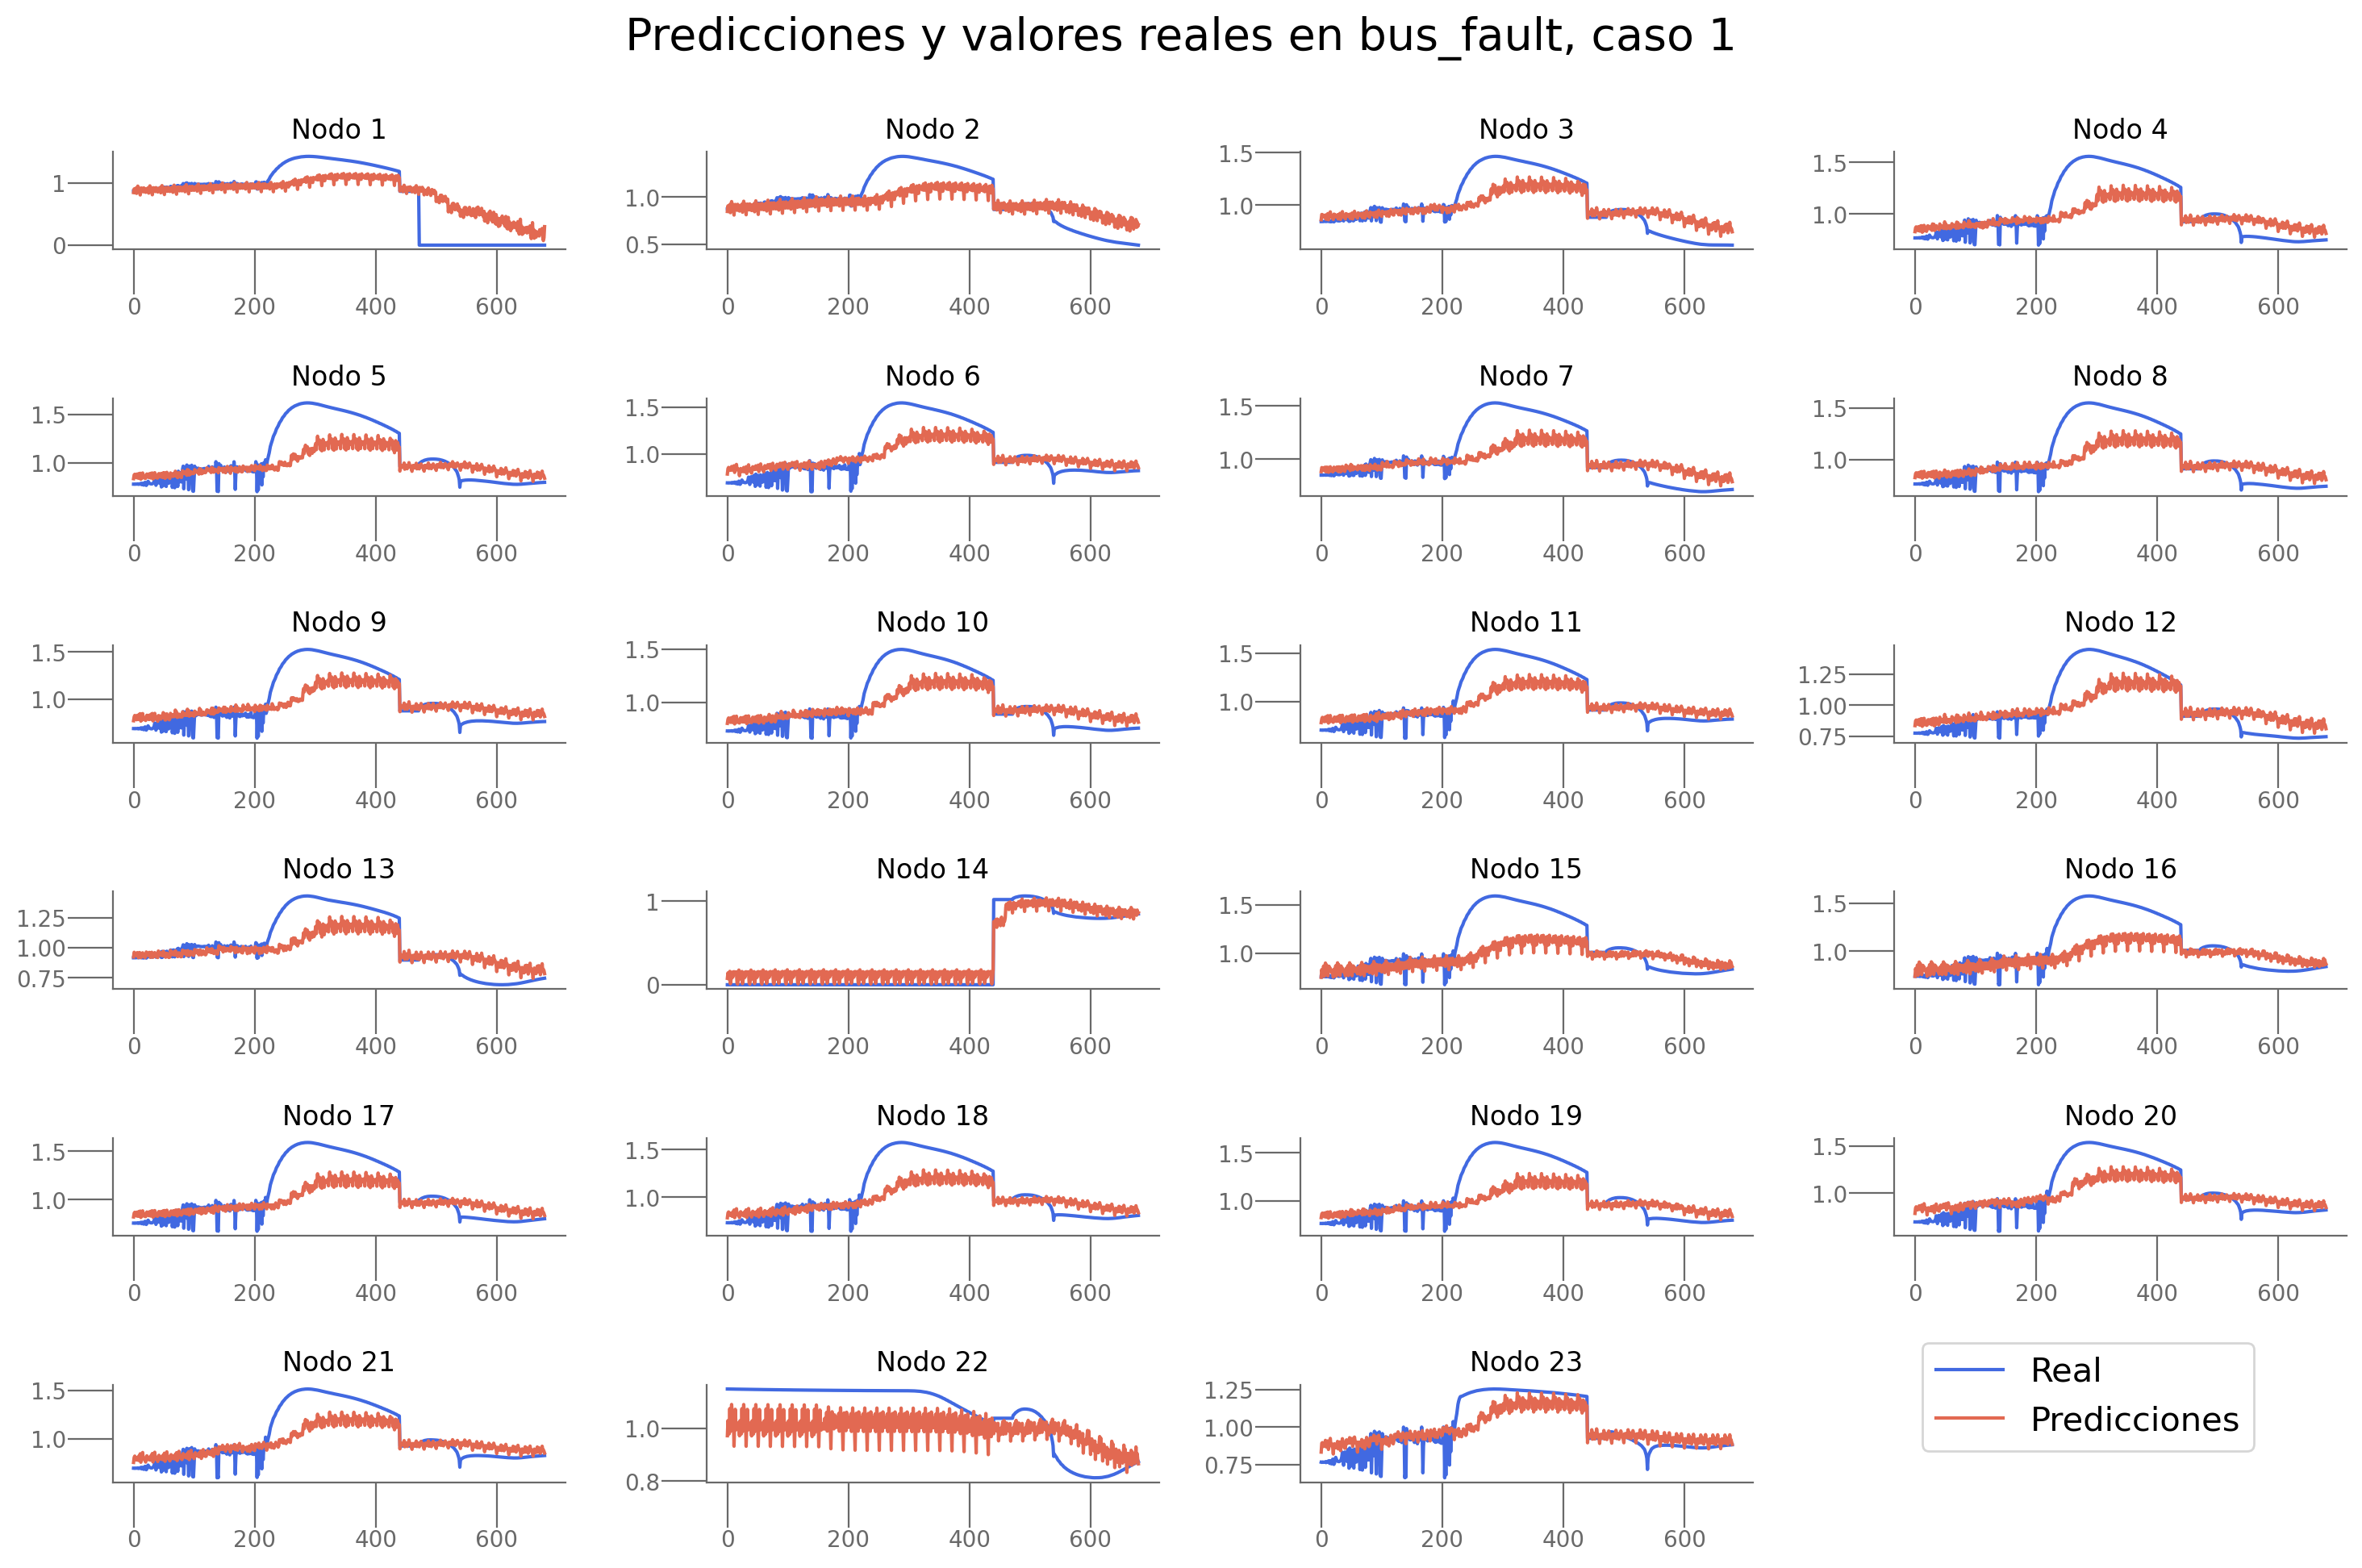

In [59]:
plot_predictions(predictions_bf, real_bf, n_target, 1,n_div_bf, problem_bf)

#### Ajuste de parámetros 

In [38]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_bf,params_bf,resultados_final_bf, resultados_bf, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_bf, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1092 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5600 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8607 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0861 | Eval R2: -1.1589 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0874 | Eval Loss: 0.0869 | Eval R2: -1.1426 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0677 | Eval R2: -0.5673 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0507 | Eval R2: -0.1592 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0491 | Eval R2: -0.3331 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0509 | Eval Loss: 0.0556 | Eval R2: -0.7378 | LR: 0.0100

 12%|█▎        | 1/8 [06:41<46:50, 401.49s/it]

Test_loss:0.0375, Test_r2:0.1483
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03504887595772743, 'r2_eval_final': 0.2149667754506941, 'loss_eval_final': 0.03508453184053644, 'r2_test': 0.14829678195282814, 'loss_test': 0.037457264519599805, 'loss_nodes': [0.02961997129023075, 0.031524479389190674, 0.030795307829976082, 0.04326203092932701, 0.04835682734847069, 0.04622136056423187, 0.03576618805527687, 0.04792538657784462, 0.04710523784160614, 0.03914264589548111, 0.04478836804628372, 0.03211897239089012, 0.02164134569466114, 0.03148755431175232, 0.03465857729315758, 0.031522538512945175, 0.04413169249892235, 0.03953021764755249, 0.048732928931713104, 0.04104926064610481, 0.040634240955114365, 0.023137642070651054, 0.02836431749165058]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9998 | Eval Loss: 0.6646 | Eval R2: -21.3004 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6670 | Eval Loss: 0.1435 | Eval R2: -3.2673

 25%|██▌       | 2/8 [13:14<39:40, 396.73s/it]

Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.01299922913312912, 'r2_eval_final': 0.5370138364009504, 'loss_eval_final': 0.013931121967261893, 'r2_test': 0.5771102815805799, 'loss_test': 0.014084230070977017, 'loss_nodes': [0.01208098791539669, 0.014354287646710873, 0.011046727187931538, 0.017093447968363762, 0.015017243102192879, 0.017043402418494225, 0.013402557000517845, 0.017635982483625412, 0.018838955089449883, 0.014193867333233356, 0.015436897985637188, 0.013206482864916325, 0.007062685675919056, 0.012002873234450817, 0.012795981019735336, 0.009762617759406567, 0.018446078523993492, 0.01295623928308487, 0.01776382140815258, 0.015441064722836018, 0.014988859184086323, 0.007971541956067085, 0.015394716523587704]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0298 | Eval Loss: 0.5931 | Eval R2: -18.4529 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6060 | Eval Loss: 0.1793 | Eval R2: -5.4291 | LR: 0.010000
Epo

 38%|███▊      | 3/8 [22:24<38:51, 466.36s/it]

Test_loss:0.0153, Test_r2:0.5725
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.013187841512262821, 'r2_eval_final': 0.5832831548605094, 'loss_eval_final': 0.015145501725097326, 'r2_test': 0.5724551253719028, 'loss_test': 0.015254601721413607, 'loss_nodes': [0.010763081721961498, 0.015327143482863903, 0.012233758345246315, 0.016374805942177773, 0.018517687916755676, 0.01956702023744583, 0.01302228681743145, 0.019314611330628395, 0.018941659480333328, 0.015684030950069427, 0.017963632941246033, 0.012151314876973629, 0.009410545229911804, 0.01148101594299078, 0.013909951783716679, 0.011401558294892311, 0.021081259474158287, 0.014885538257658482, 0.019211694598197937, 0.018061721697449684, 0.01692074164748192, 0.008876585401594639, 0.015754180029034615]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0262 | Eval Loss: 0.8002 | Eval R2: -26.9340 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7923 | Eval Loss: 0.1396 | Ev

 50%|█████     | 4/8 [31:56<33:53, 508.31s/it]

Test_loss:0.0815, Test_r2:-1.0093
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08331742882728577, 'r2_eval_final': -0.7672409076153324, 'loss_eval_final': 0.07733388944721685, 'r2_test': -1.009345695427818, 'loss_test': 0.0814963566485879, 'loss_nodes': [0.1477009505033493, 0.05984247475862503, 0.053681399673223495, 0.0966196358203888, 0.0680009052157402, 0.06806721538305283, 0.05400148779153824, 0.11497095972299576, 0.07087310403585434, 0.10881857573986053, 0.06507346779108047, 0.04942227900028229, 0.034102555364370346, 0.09574396908283234, 0.09755118936300278, 0.04643400013446808, 0.15426048636436462, 0.05715508013963699, 0.11846041679382324, 0.13483071327209473, 0.0602218396961689, 0.03118930011987686, 0.08739445358514786]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0127 | Eval Loss: 0.4534 | Eval R2: -13.4972 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4624 | Eval Loss: 0.2409 | Eval R2: -7.8839 | LR: 0.

 62%|██████▎   | 5/8 [38:52<23:44, 474.88s/it]

Test_loss:0.0373, Test_r2:0.0544
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03529909998178482, 'r2_eval_final': 0.13370438296945542, 'loss_eval_final': 0.035494785639725024, 'r2_test': 0.054368034901816534, 'loss_test': 0.03729903924733747, 'loss_nodes': [0.04385227710008621, 0.039648838341236115, 0.029447952285408974, 0.04306529834866524, 0.0441952683031559, 0.04191944748163223, 0.033967021852731705, 0.04793332889676094, 0.046092644333839417, 0.03910441696643829, 0.04168543219566345, 0.031240299344062805, 0.02055537700653076, 0.03631974756717682, 0.035231783986091614, 0.02806115336716175, 0.04453185945749283, 0.03602321818470955, 0.047064296901226044, 0.03969750553369522, 0.03736977279186249, 0.021178070455789566, 0.02969295345246792]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9976 | Eval Loss: 0.6626 | Eval R2: -21.3945 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6620 | Eval Loss: 0.1482 | Eval R2: -3

 75%|███████▌  | 6/8 [45:44<15:07, 453.50s/it]

Test_loss:0.0776, Test_r2:-0.8489
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.07819387316703796, 'r2_eval_final': -0.6340584201364261, 'loss_eval_final': 0.07381195671262283, 'r2_test': -0.8489035720780548, 'loss_test': 0.07755276716834064, 'loss_nodes': [0.14559414982795715, 0.05726493522524834, 0.049633532762527466, 0.10204965621232986, 0.06773649901151657, 0.06497487425804138, 0.05328913778066635, 0.10725124925374985, 0.0679982528090477, 0.0998312383890152, 0.06313128769397736, 0.04744795337319374, 0.03327077254652977, 0.09524816274642944, 0.090144582092762, 0.0458340086042881, 0.13659775257110596, 0.056129343807697296, 0.10971079021692276, 0.12184446305036545, 0.057695746421813965, 0.032508403062820435, 0.07852695137262344]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0250 | Eval Loss: 0.5622 | Eval R2: -17.8070 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5584 | Eval Loss: 0.1987 | Eval R2: -5.8415 | L

 88%|████████▊ | 7/8 [54:52<08:04, 484.49s/it]

Test_loss:0.0304, Test_r2:0.1683
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.029198188334703445, 'r2_eval_final': 0.15346683464637734, 'loss_eval_final': 0.02975892587083167, 'r2_test': 0.1683303942092141, 'loss_test': 0.030398150917879025, 'loss_nodes': [0.04218930006027222, 0.03647483512759209, 0.026378212496638298, 0.03377194702625275, 0.03377347066998482, 0.03643910214304924, 0.026040155440568924, 0.035057950764894485, 0.034402091056108475, 0.029124373570084572, 0.0322098582983017, 0.023859769105911255, 0.015505751594901085, 0.0339953675866127, 0.027956081554293633, 0.025433752685785294, 0.035061635076999664, 0.02854005992412567, 0.03730747476220131, 0.03320879489183426, 0.030856478959321976, 0.016008885577321053, 0.025562189519405365]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0628 | Eval Loss: 0.8605 | Eval R2: -28.6735 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8622 | Eval Loss: 0.1891 | Eval R2:

100%|██████████| 8/8 [1:04:59<00:00, 487.50s/it]

Test_loss:0.0810, Test_r2:-0.9101
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.0825948715209961, 'r2_eval_final': -0.7274237965688775, 'loss_eval_final': 0.07804089078048095, 'r2_test': -0.9100995974718089, 'loss_test': 0.08096241064607924, 'loss_nodes': [0.14877820014953613, 0.05635567009449005, 0.05013884976506233, 0.1063566729426384, 0.06777995824813843, 0.06555211544036865, 0.05324350669980049, 0.1098012775182724, 0.06622827053070068, 0.10889091342687607, 0.06287404894828796, 0.04709934815764427, 0.03397751227021217, 0.09841068089008331, 0.09884274750947952, 0.04644152894616127, 0.1524505913257599, 0.05639757961034775, 0.11609839648008347, 0.1389385610818863, 0.05763187259435654, 0.03356781229376793, 0.0862792506814003]}


In [43]:
losses_tst, r2score_tst, loss_nodes_bf, predictions_bf_ajuste, real_bf_ajuste = test(modelo_bf, dataloader_bf, modelo_bf.h)



==================== TEST INFO ===================

Test_loss:0.0141, Test_r2:0.5771


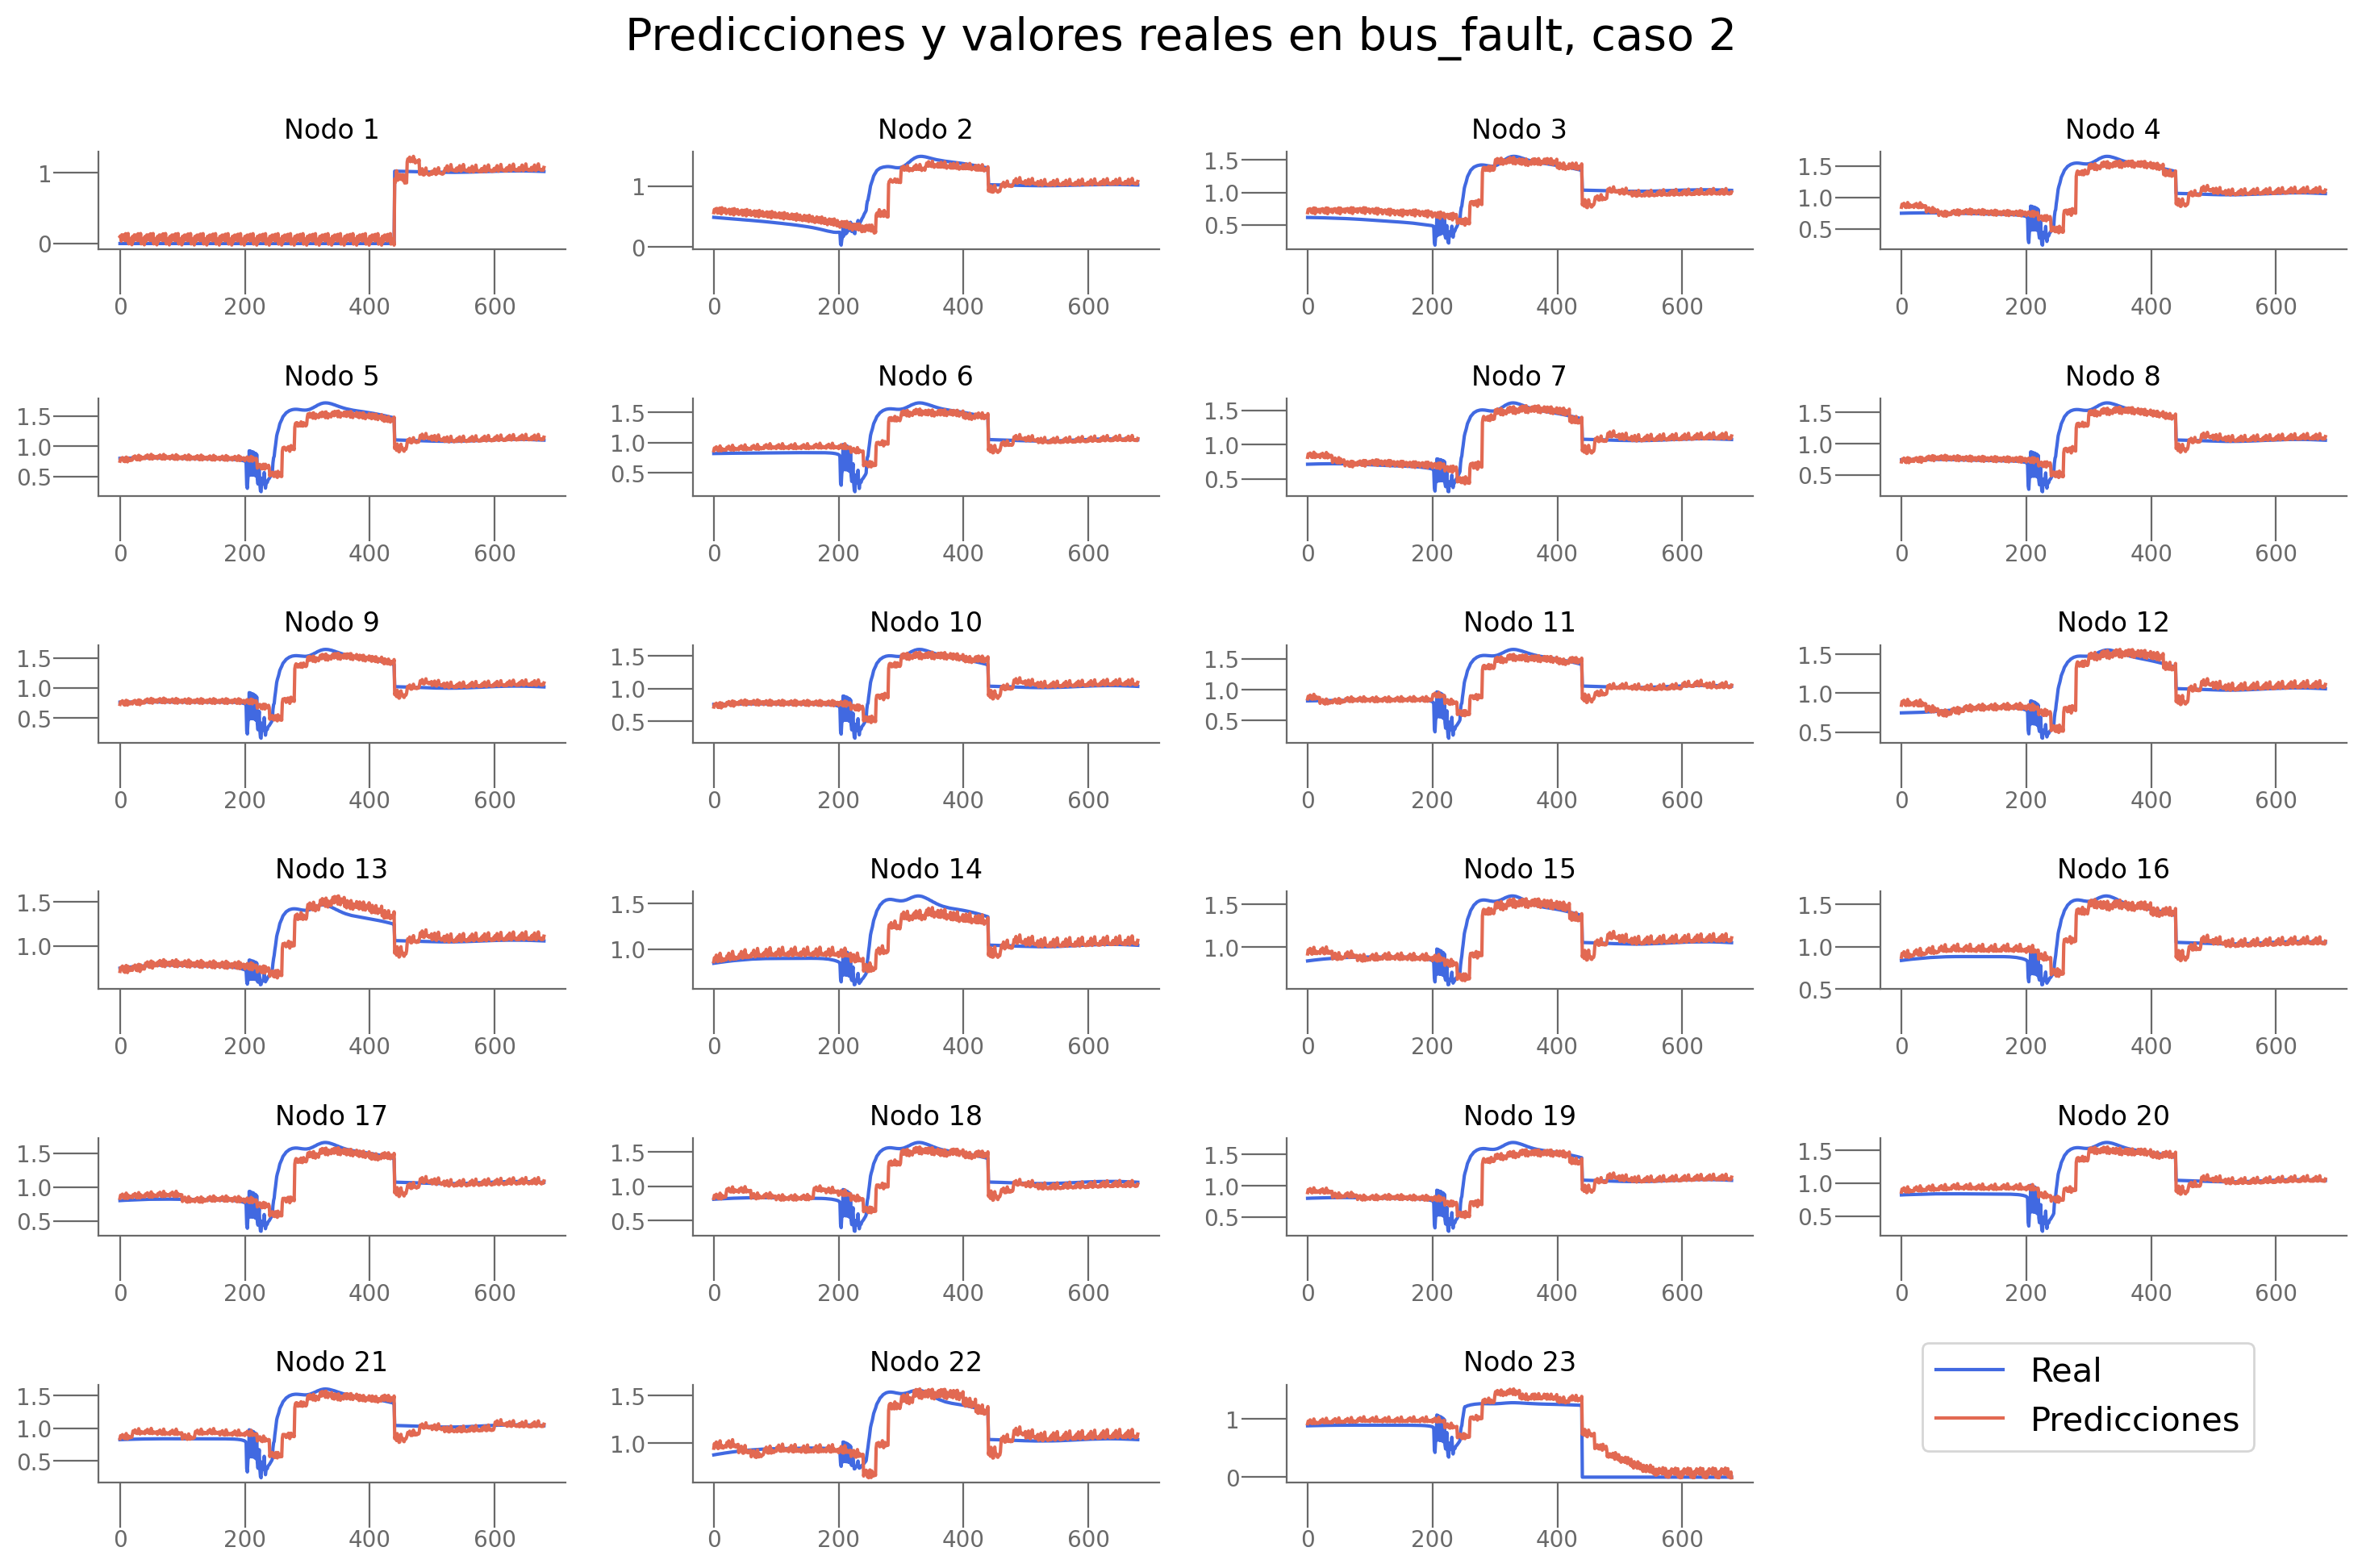

In [44]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 2, n_div_bf, problem_bf)

In [39]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [40]:
guardar_resultados(modelo_bf, "DryGrEncoder", problem_bf, resultados_final_bf, results_save_path, path_save_experiment_bf, params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo       Params  \
0          LSTM          NaN   
1  DryGrEncoder  (add, 1, 2)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.016884  0.601978   
1  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.014084  0.577110   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01173629 0.00995132 0.0126239  0.01929585 0... -7.654841   0.181827   
1  [0.01208098791539669, 0.014354287646710873, 0....  0.537014   0.013931   

   Loss_final  
0    0.016603  
1    0.012999  

==================== RESULTADOS GUARDADOS ===================



### Branch Fault

In [46]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [47]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

dataloader_brf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

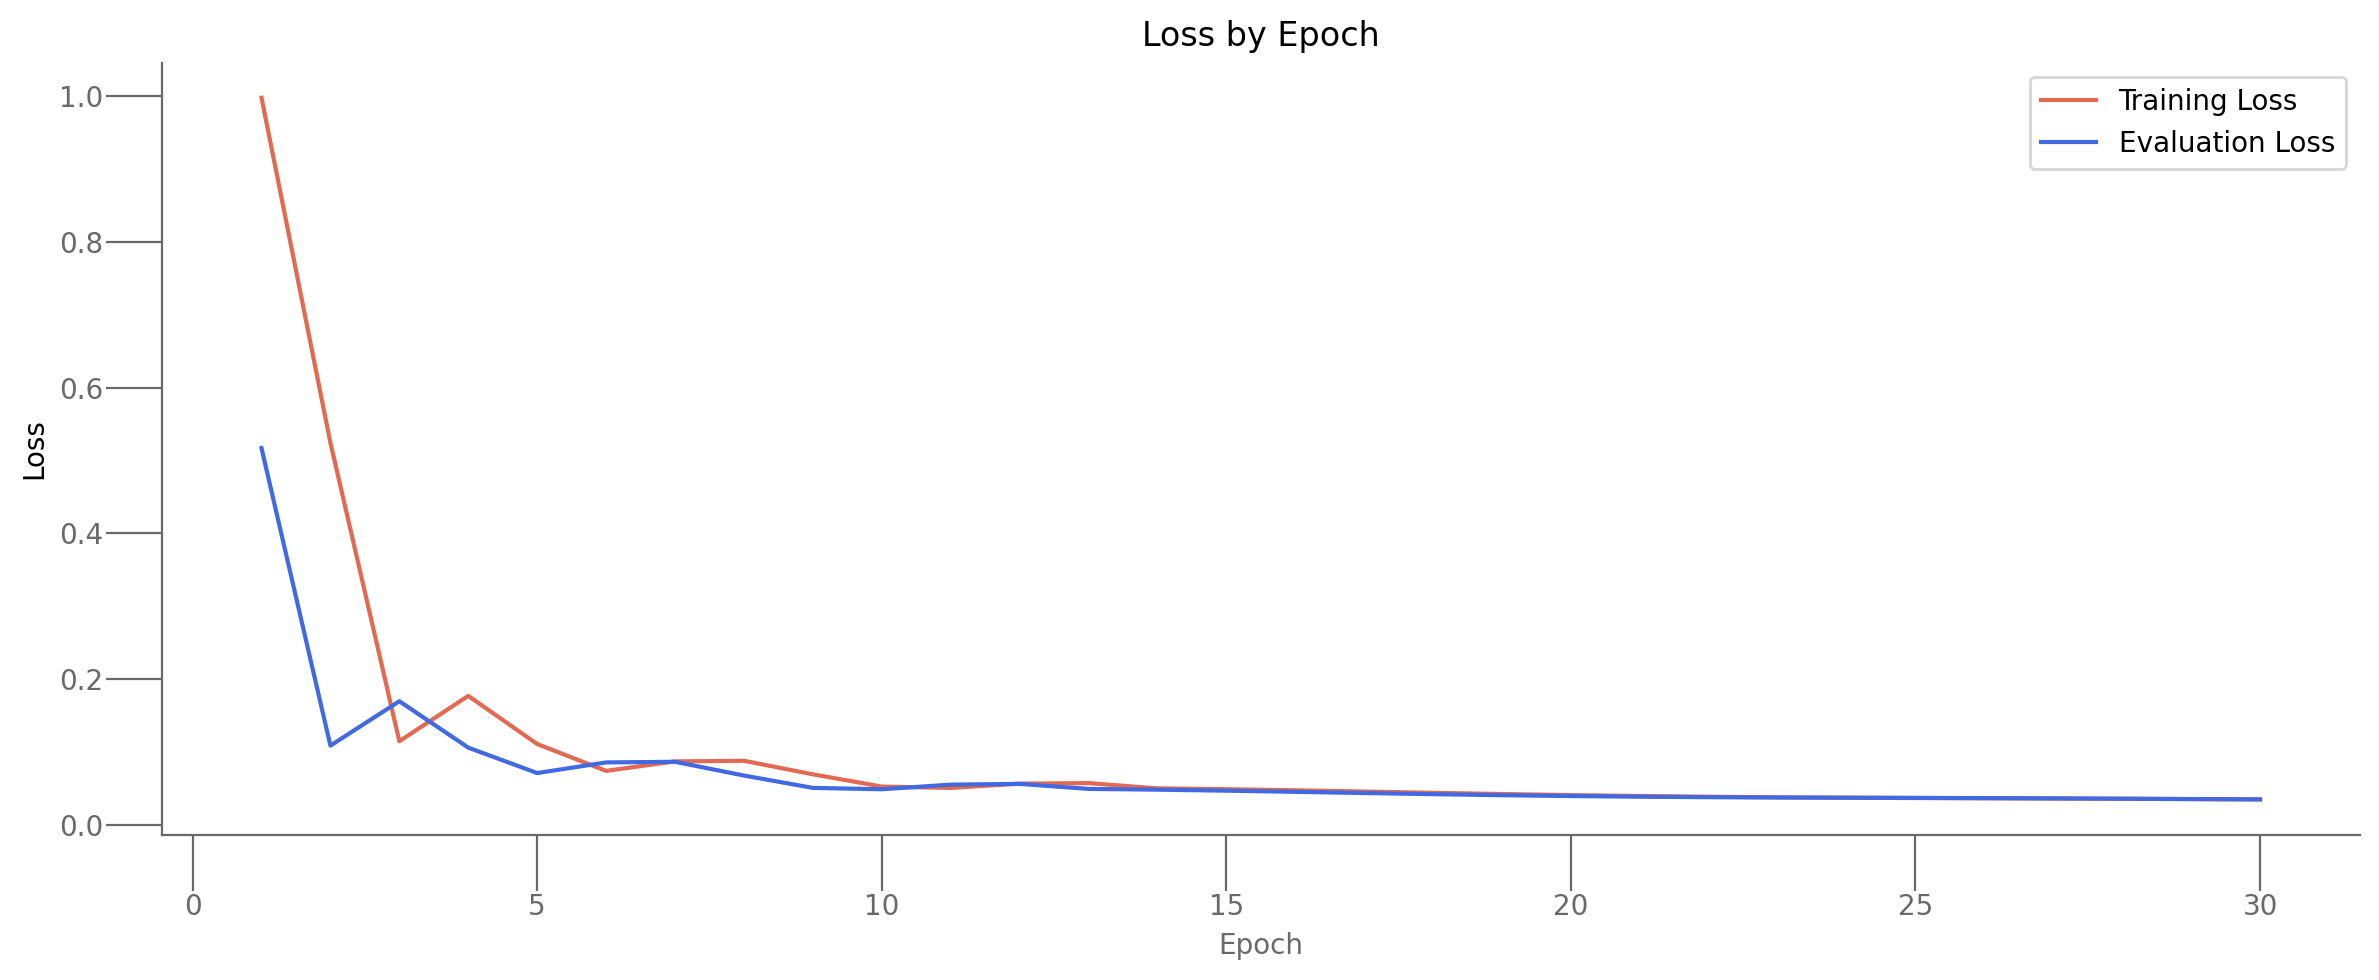


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [63]:

model_brf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brf, dataloader_brf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_brf, predictions_brf, real_brf = test(model_brf, dataloader_brf, h)


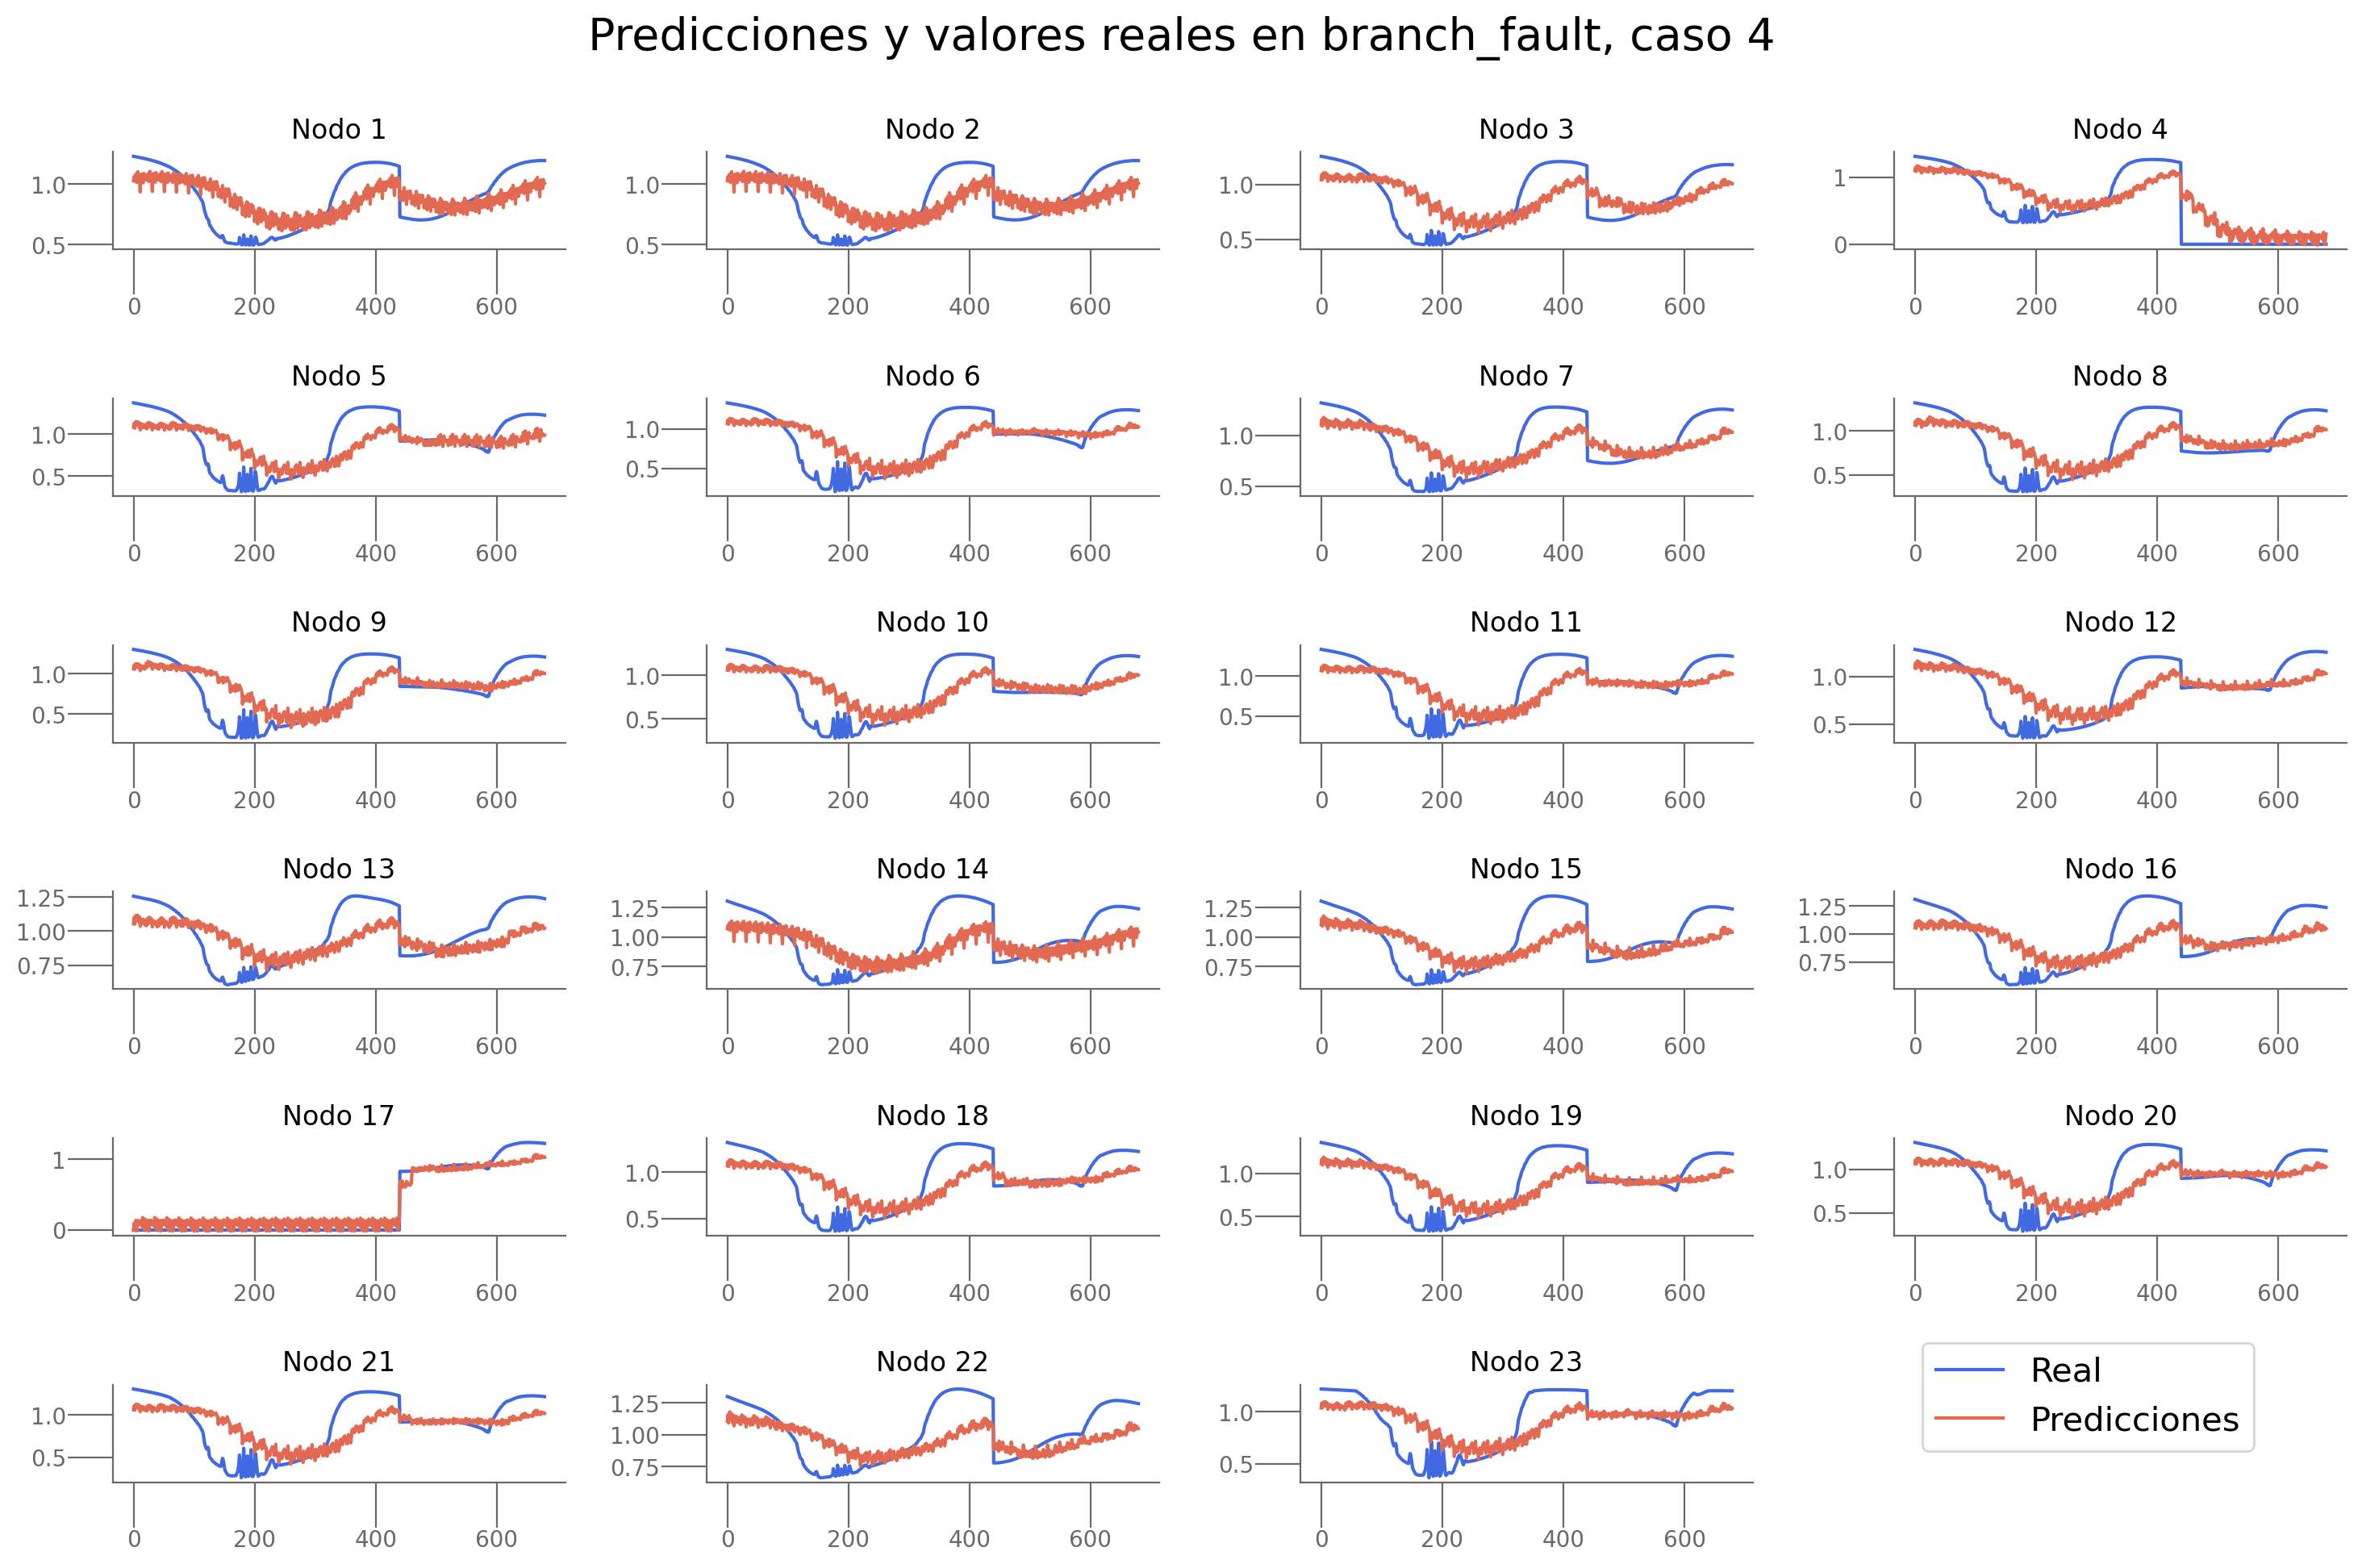

In [64]:
plot_predictions(predictions_brf, real_brf, n_target, 4,  n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [48]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_brf,params_brf,resultados_final_brf, resultados_brf, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_brf, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1092 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8605 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0741 | Eval Loss: 0.0860 | Eval R2: -1.1578 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0873 | Eval Loss: 0.0870 | Eval R2: -1.1532 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5686 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0694 | Eval Loss: 0.0507 | Eval R2: -0.1581 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0525 | Eval Loss: 0.0491 | Eval R2: -0.3337 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0508 | Eval Loss: 0.0557 | Eval R2: -0.7409 | LR: 0.0100

 12%|█▎        | 1/8 [07:32<52:48, 452.71s/it]

Test_loss:0.0376, Test_r2:0.1470
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.034898336976766586, 'r2_eval_final': 0.21504550967261102, 'loss_eval_final': 0.03489645688858783, 'r2_test': 0.14700801744577482, 'loss_test': 0.037610419444620694, 'loss_nodes': [0.029657339677214622, 0.03162076324224472, 0.031009431928396225, 0.043395791202783585, 0.048472434282302856, 0.046266108751297, 0.03606223315000534, 0.0481371209025383, 0.04723349213600159, 0.03914602845907211, 0.04493648186326027, 0.03229491785168648, 0.021830009296536446, 0.03166819363832474, 0.03501151502132416, 0.031788527965545654, 0.04401923343539238, 0.03970915824174881, 0.04910982772707939, 0.04113893210887909, 0.04078132286667824, 0.023532342165708542, 0.028218451887369156]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9998 | Eval Loss: 0.6646 | Eval R2: -21.3004 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6670 | Eval Loss: 0.1435 | Eval R2: -3.267

 25%|██▌       | 2/8 [14:02<41:35, 415.87s/it]

Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.014402590692043304, 'r2_eval_final': 0.5373121225791289, 'loss_eval_final': 0.014043626115368357, 'r2_test': 0.5068902925655494, 'loss_test': 0.014330437694416316, 'loss_nodes': [0.012768067419528961, 0.014942342415452003, 0.011256908066570759, 0.01665751449763775, 0.015761448070406914, 0.01738525927066803, 0.012543552555143833, 0.018028896301984787, 0.018849432468414307, 0.0142911896109581, 0.0168781541287899, 0.012666907161474228, 0.006821800488978624, 0.012806480750441551, 0.012706641107797623, 0.01046826969832182, 0.019223704934120178, 0.01336523424834013, 0.01836307905614376, 0.016046572476625443, 0.015583908185362816, 0.007484883069992065, 0.014699828810989857]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0298 | Eval Loss: 0.5931 | Eval R2: -18.4528 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6060 | Eval Loss: 0.1793 | Eval R2: -5.4291 | LR: 0.010000
Epoch 3/

 38%|███▊      | 3/8 [23:22<40:07, 481.48s/it]

Test_loss:0.0151, Test_r2:0.5764
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.01305139809846878, 'r2_eval_final': 0.5761045225578307, 'loss_eval_final': 0.014627642092701775, 'r2_test': 0.5763977091014055, 'loss_test': 0.015149368036830755, 'loss_nodes': [0.010656297206878662, 0.014884302392601967, 0.011409108527004719, 0.016865000128746033, 0.017823554575443268, 0.020515672862529755, 0.014558813534677029, 0.01944584585726261, 0.01865542121231556, 0.014272346161305904, 0.017627444118261337, 0.013580474071204662, 0.007672708481550217, 0.011333012022078037, 0.013267319649457932, 0.012284837663173676, 0.02054498717188835, 0.014650348573923111, 0.019536959007382393, 0.01728695072233677, 0.017510855570435524, 0.007886119186878204, 0.016167132183909416]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0262 | Eval Loss: 0.8002 | Eval R2: -26.9340 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7923 | Eval Loss: 0.1396 | Eva

 50%|█████     | 4/8 [33:10<34:54, 523.74s/it]

Test_loss:0.0816, Test_r2:-1.0127
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.0827062800526619, 'r2_eval_final': -0.7589251587760176, 'loss_eval_final': 0.07688174686159124, 'r2_test': -1.0126988026162012, 'loss_test': 0.08163887415037946, 'loss_nodes': [0.1478460282087326, 0.05998016893863678, 0.05354654788970947, 0.11025309562683105, 0.06774283945560455, 0.06815818697214127, 0.05392542481422424, 0.11235089600086212, 0.0711614266037941, 0.1081550121307373, 0.06468521058559418, 0.049031298607587814, 0.0340518057346344, 0.09575528651475906, 0.09762390702962875, 0.0463671050965786, 0.1504218578338623, 0.05701584741473198, 0.11621476709842682, 0.1342918872833252, 0.06012863665819168, 0.03119061514735222, 0.08779634535312653]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0127 | Eval Loss: 0.4534 | Eval R2: -13.4972 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4624 | Eval Loss: 0.2409 | Eval R2: -7.8839 | LR: 0.010

 62%|██████▎   | 5/8 [40:40<24:51, 497.13s/it]

Test_loss:0.0373, Test_r2:0.0548
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03530774638056755, 'r2_eval_final': 0.13313500556943447, 'loss_eval_final': 0.035541948247915026, 'r2_test': 0.054811222091265356, 'loss_test': 0.037291344214057505, 'loss_nodes': [0.04382775351405144, 0.03962980583310127, 0.029425423592329025, 0.04313505440950394, 0.04417826235294342, 0.04184902831912041, 0.03408745303750038, 0.047893572598695755, 0.046003639698028564, 0.039105117321014404, 0.04160553589463234, 0.031249497085809708, 0.02067824825644493, 0.036333173513412476, 0.035219043493270874, 0.02799091301858425, 0.044537611305713654, 0.036054592579603195, 0.04719534516334534, 0.039643432945013046, 0.03729494661092758, 0.02121555246412754, 0.02954791486263275]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9976 | Eval Loss: 0.6626 | Eval R2: -21.3945 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6620 | Eval Loss: 0.1482 | Eval R2

 75%|███████▌  | 6/8 [47:42<15:42, 471.42s/it]

Test_loss:0.0769, Test_r2:-0.8329
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.07766705751419067, 'r2_eval_final': -0.619289690050435, 'loss_eval_final': 0.07318528472263923, 'r2_test': -0.8328988383088375, 'loss_test': 0.07689817694643902, 'loss_nodes': [0.14568981528282166, 0.05732891336083412, 0.04966719448566437, 0.10034050792455673, 0.06769074499607086, 0.06499951332807541, 0.05331782251596451, 0.10592413693666458, 0.06802035123109818, 0.09788740426301956, 0.06316447257995605, 0.04753883183002472, 0.03334666043519974, 0.09524030238389969, 0.08879043161869049, 0.04582660272717476, 0.13458353281021118, 0.05621473118662834, 0.1092253103852272, 0.11725223809480667, 0.05767892301082611, 0.032575465738773346, 0.07635410875082016]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0250 | Eval Loss: 0.5622 | Eval R2: -17.8070 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5584 | Eval Loss: 0.1987 | Eval R2: -5.8415 | L

 88%|████████▊ | 7/8 [57:15<08:24, 504.61s/it]

Test_loss:0.0307, Test_r2:0.1512
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.029506031423807144, 'r2_eval_final': 0.1504807778466676, 'loss_eval_final': 0.02973193853783111, 'r2_test': 0.1512260775714821, 'loss_test': 0.030679818148573124, 'loss_nodes': [0.04257325828075409, 0.03664974495768547, 0.027749227359890938, 0.03373339772224426, 0.03432494401931763, 0.0361621230840683, 0.025996681302785873, 0.03570340573787689, 0.035580821335315704, 0.029871195554733276, 0.03244080767035484, 0.024391334503889084, 0.015959594398736954, 0.03416033089160919, 0.028431573882699013, 0.025617701932787895, 0.03516598045825958, 0.0290470439940691, 0.0377771370112896, 0.03305293247103691, 0.030488494783639908, 0.016297077760100365, 0.02446109615266323]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0628 | Eval Loss: 0.8605 | Eval R2: -28.6735 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8622 | Eval Loss: 0.1891 | Eval R2: -4.9

100%|██████████| 8/8 [1:56:25<00:00, 873.17s/it] 

Test_loss:0.0809, Test_r2:-0.9024
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08243588358163834, 'r2_eval_final': -0.7247105924565855, 'loss_eval_final': 0.07798472188959091, 'r2_test': -0.9023727237222608, 'loss_test': 0.08090812303883911, 'loss_nodes': [0.14909639954566956, 0.05645189434289932, 0.05000859498977661, 0.10581401735544205, 0.06736220419406891, 0.06504202634096146, 0.052905935794115067, 0.10885363072156906, 0.06553184241056442, 0.10855589061975479, 0.06240737810730934, 0.04647891968488693, 0.03428354114294052, 0.0984354093670845, 0.09795170277357101, 0.0462726466357708, 0.152042418718338, 0.0562928281724453, 0.1183067262172699, 0.14066435396671295, 0.05744049325585365, 0.03365693613886833, 0.08703125268220901]}


In [49]:
losses_tst, r2score_tst, loss_nodes_brf, predictions_brf_ajuste, real_brf_ajuste = test(modelo_brf, dataloader_brf, modelo_brf.h)



==================== TEST INFO ===================

Test_loss:0.0143, Test_r2:0.5069


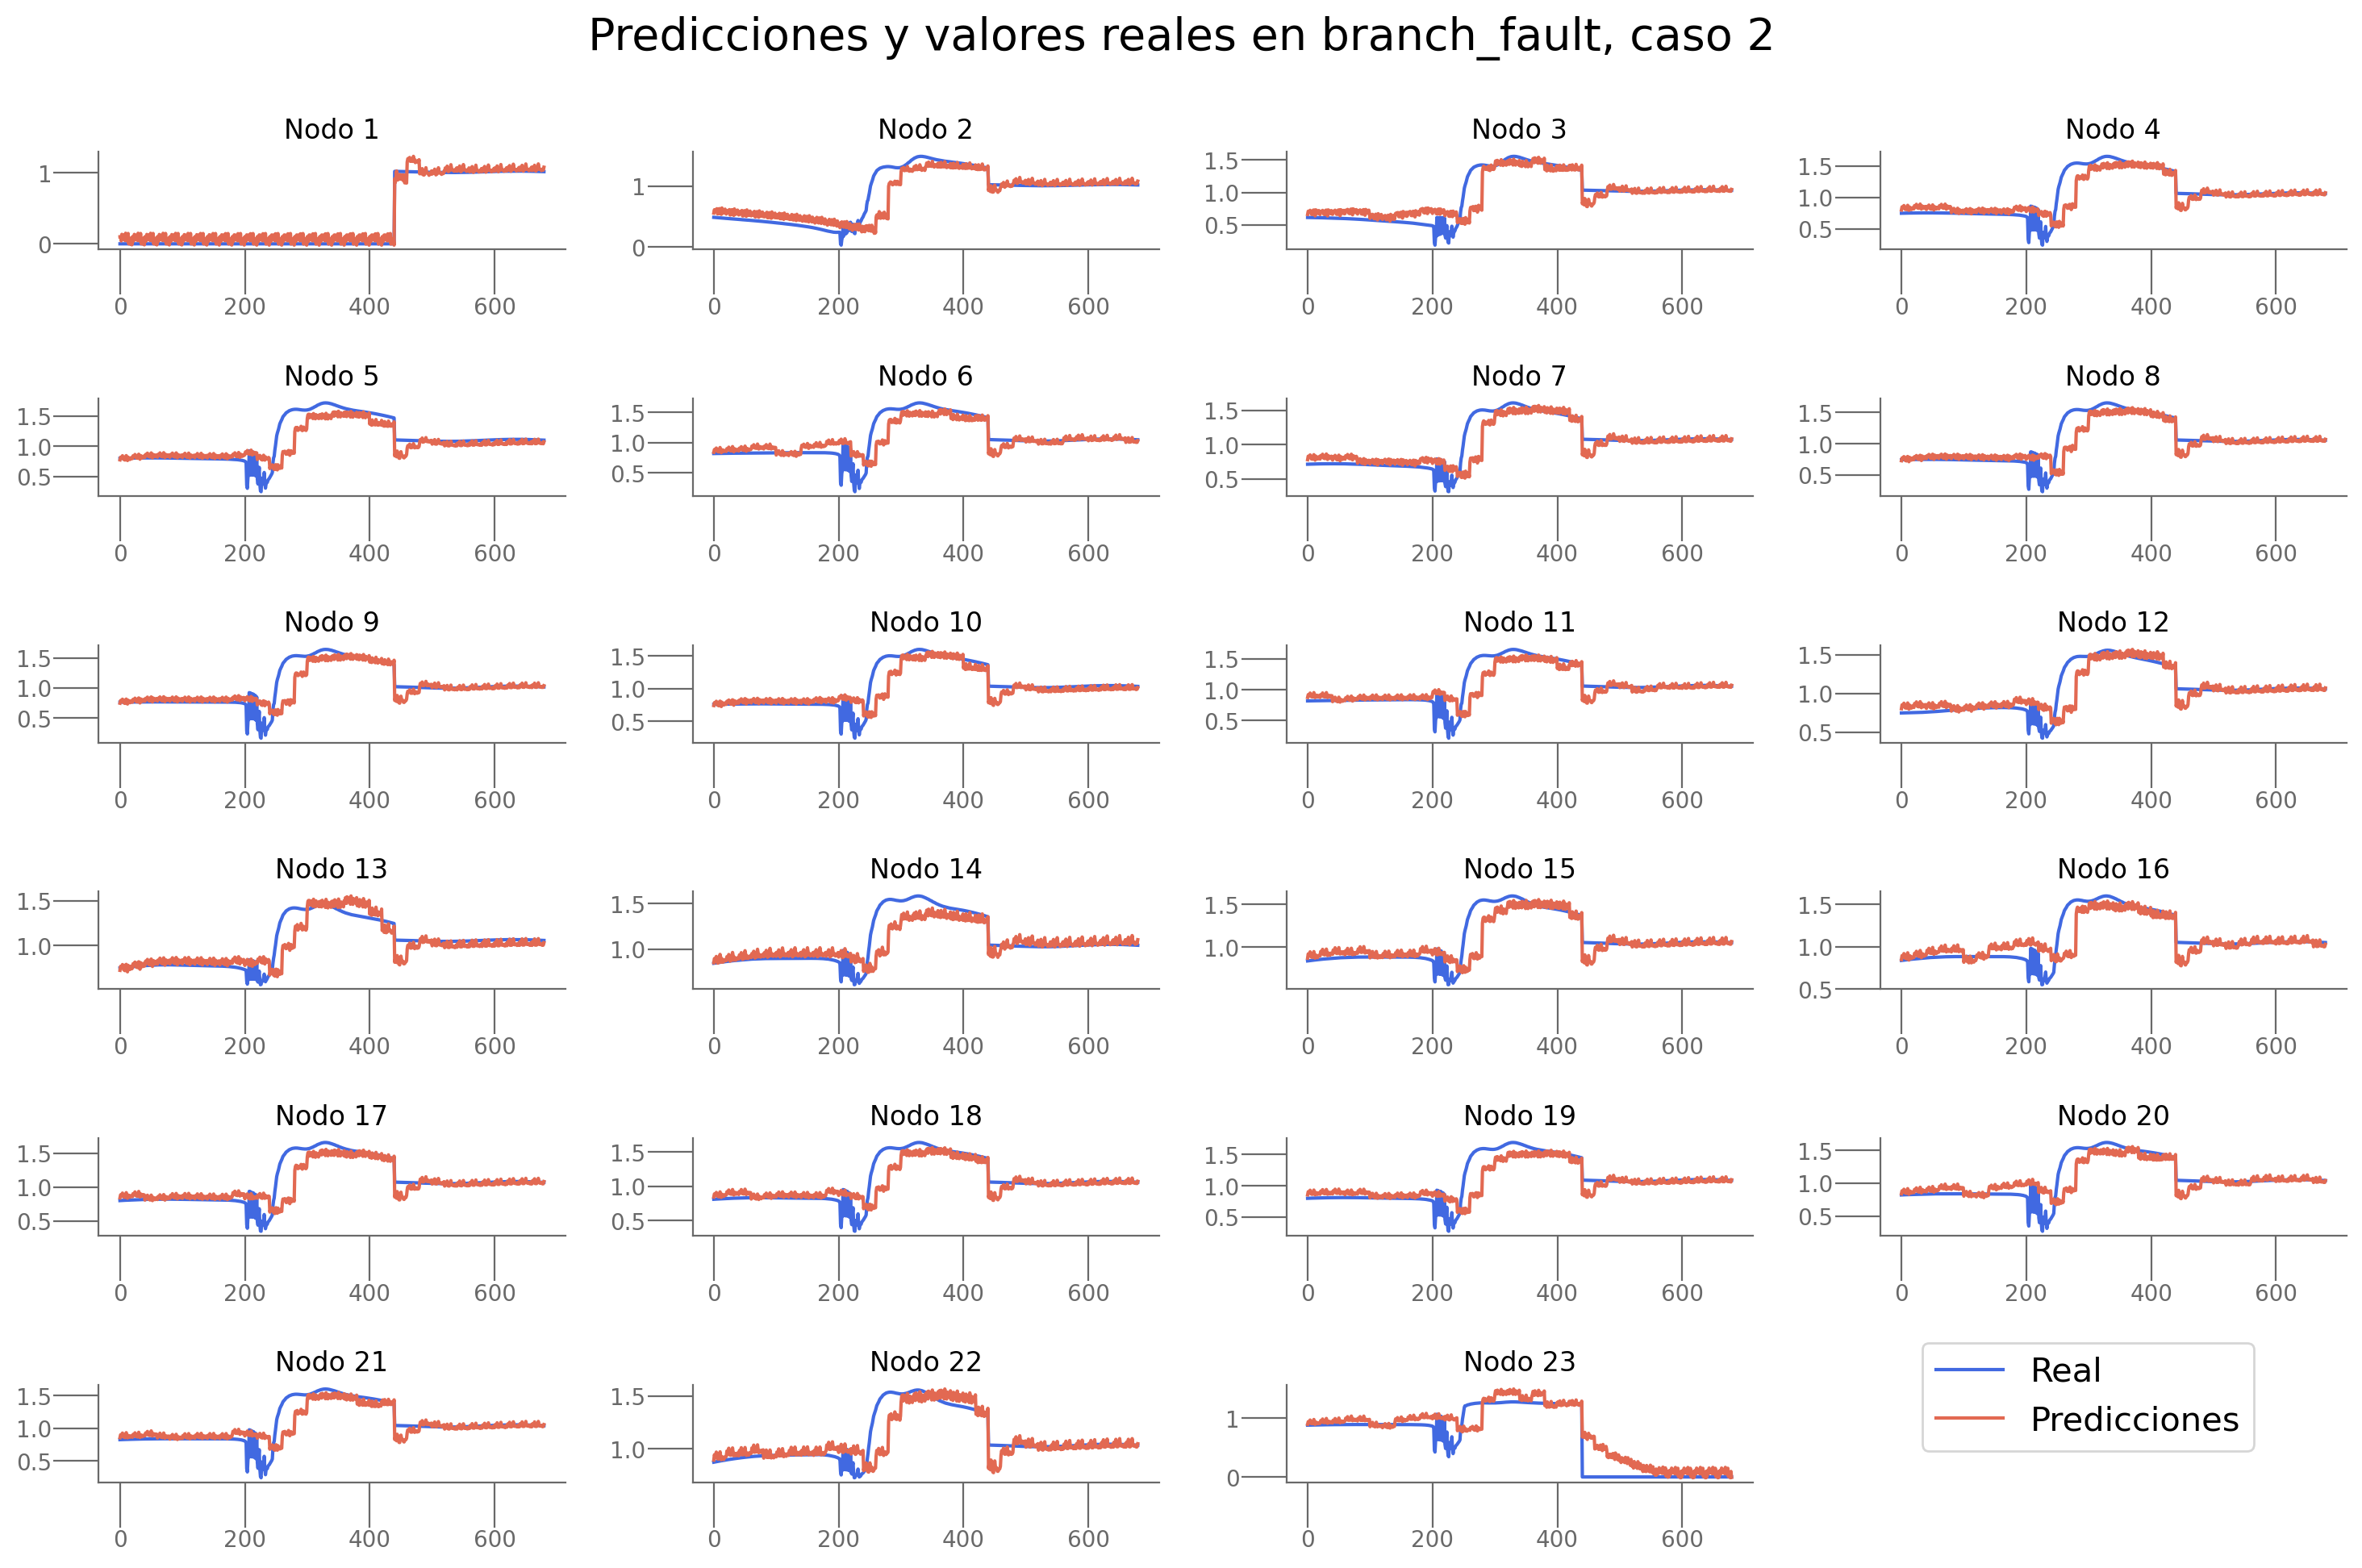

In [50]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 2, n_div_brf, problem_brf)

In [51]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [58]:
guardar_resultados(modelo_brf, "DryGrEncoder", problem_brf, resultados_final_brf, results_save_path, path_save_experiment_brf, params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo       Params  \
0          LSTM          NaN   
1  DryGrEncoder  (add, 1, 2)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.019392  0.702621   
1  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.014330  0.506890   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00679742 0.00685346 0.01119131 0.02153048 0... -4.979866   0.237984   
1  [0.012768067419528961, 0.014942342415452003, 0...  0.537312   0.014044   

   Loss_final  
0    0.017030  
1    0.014403  

==================== RESULTADOS GUARDADOS ===================



### Branch trip

In [18]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [19]:
n_div_brt = loader.div

In [20]:
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

dataloader_brt = trainer.train_test_val_split(dataset_brt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

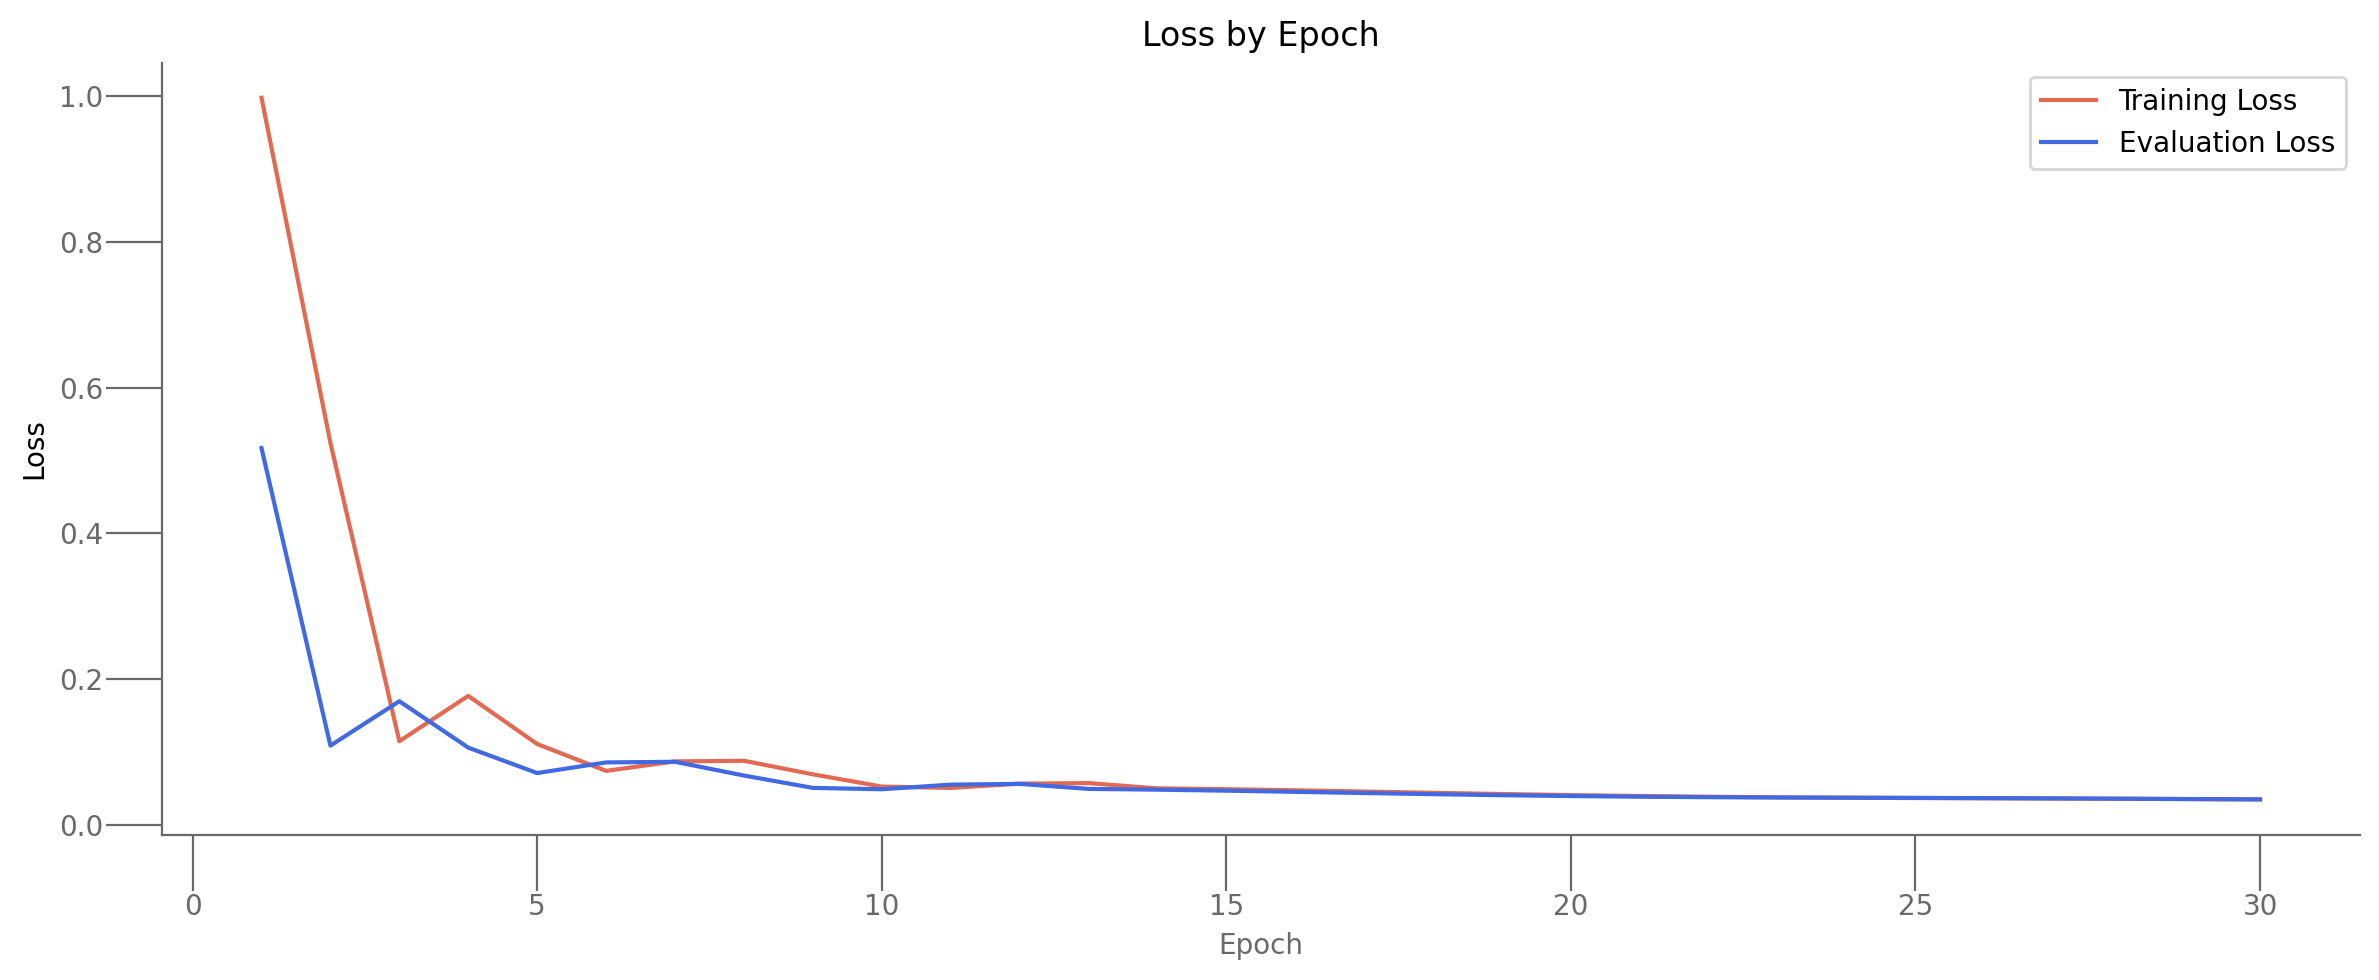


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [68]:


model_brt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brt, dataloader_brt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_brt, predictions_brt, real_brt = test(model_brt, dataloader_brt, h)


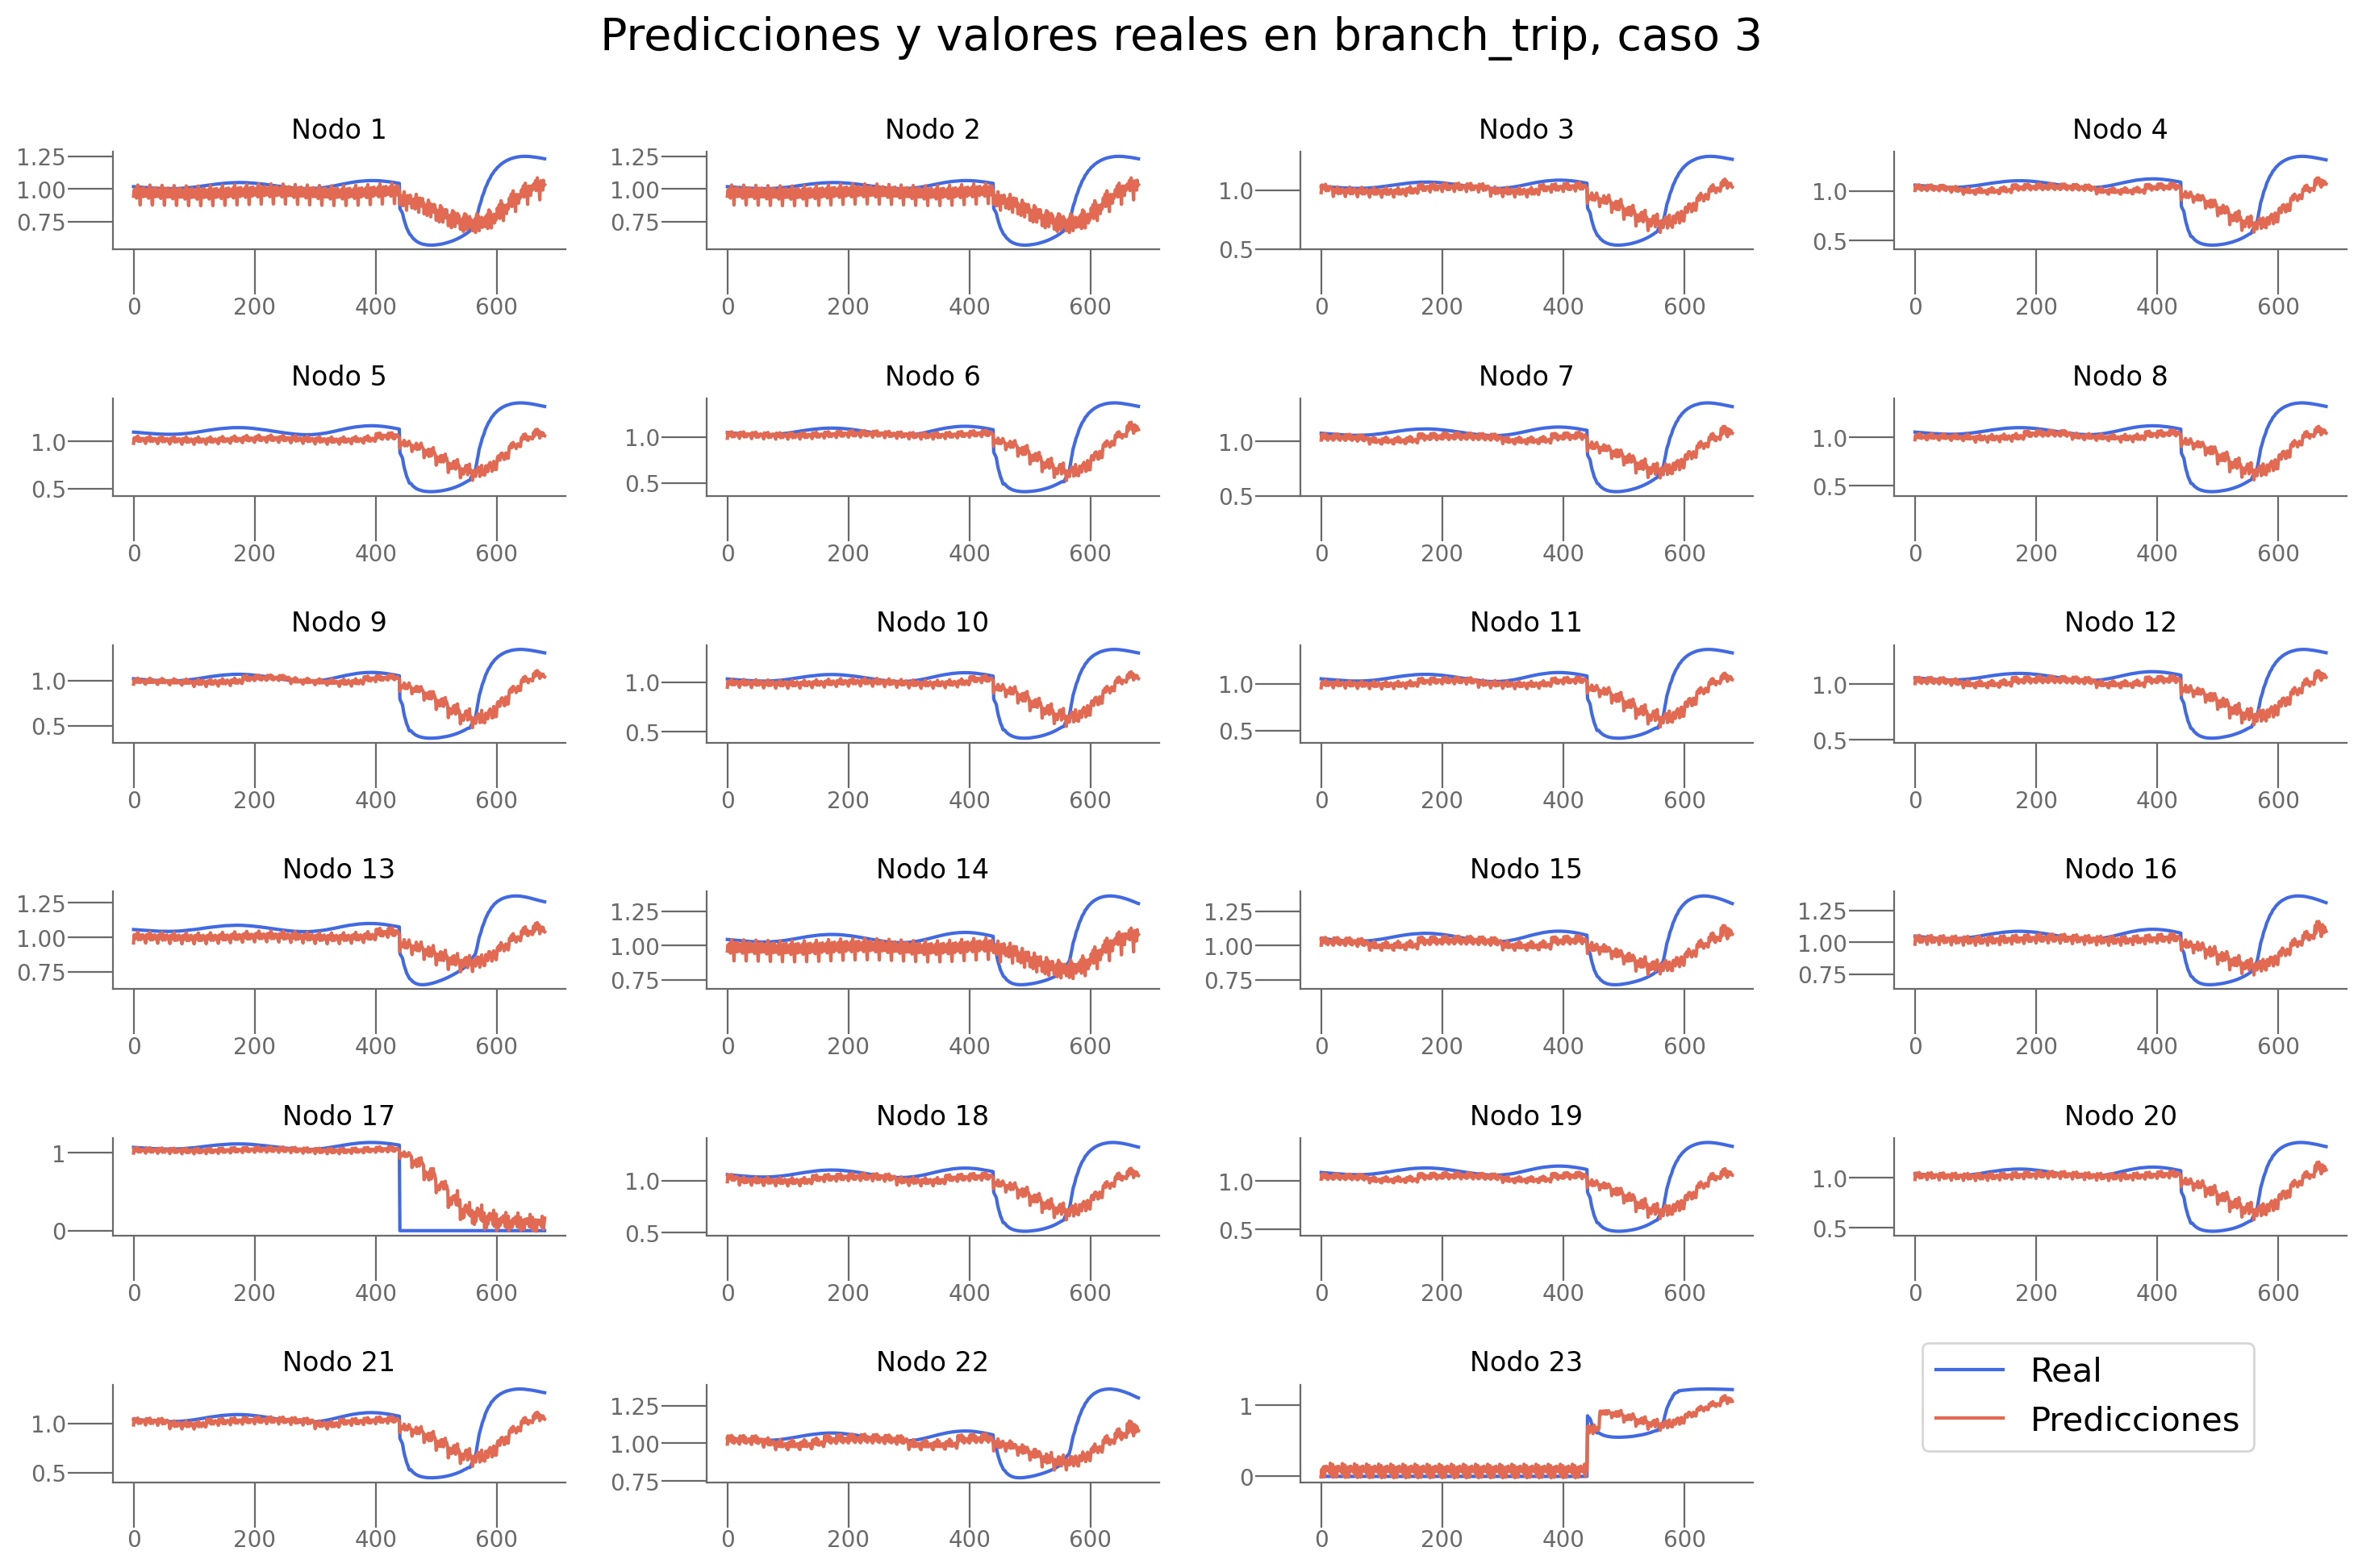

In [69]:
plot_predictions(predictions_brt, real_brt, n_target, 3, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [23]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_brt,params_brt, resultados_final_brt, resultados_brt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_brt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0043 | Eval Loss: 0.5253 | Eval R2: -442.8531 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5165 | Eval Loss: 0.0836 | Eval R2: -55.2140 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0789 | Eval Loss: 0.1455 | Eval R2: -81.9884 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1443 | Eval Loss: 0.0996 | Eval R2: -50.0141 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0985 | Eval Loss: 0.0593 | Eval R2: -28.5015 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0562 | Eval Loss: 0.0659 | Eval R2: -42.7682 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0612 | Eval Loss: 0.0766 | Eval R2: -55.6577 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0711 | Eval Loss: 0.0684 | Eval R2: -49.2606 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0630 | Eval Loss: 0.0662 | Eval R2: -47.2382 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0608 | Eval Loss: 0.0629 | Eval R2: -44.1444 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.0576 | Eval Loss: 0.0591 | Eval R2: -40.4094 |

 12%|█▎        | 1/8 [07:21<51:28, 441.28s/it]

Test_loss:0.0415, Test_r2:-16.6327
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03602133318781853, 'r2_eval_final': -15.474853741812577, 'loss_eval_final': 0.03906896098941455, 'r2_test': -16.632721709529065, 'loss_test': 0.041499528412402856, 'loss_nodes': [0.029318422079086304, 0.025621090084314346, 0.033978767693042755, 0.04766882210969925, 0.05318408086895943, 0.05383996292948723, 0.03847939148545265, 0.04983443021774292, 0.05704330652952194, 0.04722023010253906, 0.05237611010670662, 0.04036707431077957, 0.02312837541103363, 0.03460120037198067, 0.03756740316748619, 0.03602121025323868, 0.046007923781871796, 0.045304812490940094, 0.05085475370287895, 0.04702956601977348, 0.047923196107149124, 0.02896183356642723, 0.028157226741313934]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0078 | Eval Loss: 0.6661 | Eval R2: -558.1983 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6532 | Eval Loss: 0.0883 | Eval R2: -5

 25%|██▌       | 2/8 [17:45<54:54, 549.01s/it]

Test_loss:0.0480, Test_r2:-19.6482
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.04083778336644173, 'r2_eval_final': -18.32444308769436, 'loss_eval_final': 0.043516777989719355, 'r2_test': -19.648215770841613, 'loss_test': 0.0480432974013251, 'loss_nodes': [0.03304613009095192, 0.029810212552547455, 0.038681600242853165, 0.05487861484289169, 0.06324039399623871, 0.06209415942430496, 0.0459851510822773, 0.05705513432621956, 0.06385084241628647, 0.05428950488567352, 0.060270894318819046, 0.04581879451870918, 0.028699874877929688, 0.039873890578746796, 0.043460000306367874, 0.042869932949543, 0.053564902395009995, 0.052608370780944824, 0.059743400663137436, 0.054060645401477814, 0.054888300597667694, 0.03407243639230728, 0.03213275223970413]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0462 | Eval Loss: 0.7143 | Eval R2: -599.0849 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7062 | Eval Loss: 0.1394 | Eval R2: -98

 38%|███▊      | 3/8 [28:16<48:51, 586.20s/it]

Test_loss:0.0129, Test_r2:-5.7763
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.010423426516354084, 'r2_eval_final': -5.519814458340733, 'loss_eval_final': 0.011722813405475452, 'r2_test': -5.776269923309604, 'loss_test': 0.012905595631633729, 'loss_nodes': [0.013736667111515999, 0.011711248196661472, 0.009290861897170544, 0.01359925139695406, 0.014253590255975723, 0.01641157828271389, 0.01162872277200222, 0.012978325597941875, 0.016233813017606735, 0.010738556273281574, 0.015149926766753197, 0.010796034708619118, 0.008439073339104652, 0.018560675904154778, 0.01159826572984457, 0.010363913141191006, 0.012999774888157845, 0.012749837711453438, 0.016553465276956558, 0.014327780343592167, 0.014745245687663555, 0.008444119244813919, 0.011517968960106373]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0358 | Eval Loss: 0.7801 | Eval R2: -662.7780 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7806 | Eval Loss: 0.1151 | 

 50%|█████     | 4/8 [39:48<41:52, 628.18s/it]

Test_loss:0.0484, Test_r2:-20.3794
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.0405568964779377, 'r2_eval_final': -19.045167268027622, 'loss_eval_final': 0.04351941084617055, 'r2_test': -20.379436845790288, 'loss_test': 0.048381391544780224, 'loss_nodes': [0.033594753593206406, 0.030667541548609734, 0.038982272148132324, 0.054701969027519226, 0.06389103084802628, 0.0623665414750576, 0.04641569405794144, 0.05670404061675072, 0.06287305057048798, 0.05416271463036537, 0.06033805012702942, 0.04531486704945564, 0.02971489727497101, 0.04101942107081413, 0.0438716858625412, 0.0440252348780632, 0.054073359817266464, 0.0530618280172348, 0.060020897537469864, 0.05448658764362335, 0.055103402584791183, 0.03471112996339798, 0.03267114982008934]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0145 | Eval Loss: 0.4683 | Eval R2: -393.3468 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4649 | Eval Loss: 0.1965 | Eval R2: -136.49

In [ ]:
losses_tst, r2score_tst, loss_nodes_brt, predictions_brt_ajuste, real_brt_ajuste = test(modelo_brt, dataloader_brt, modelo_brt.h)



==================== TEST INFO ===================

Test_loss:0.0143, Test_r2:0.5069


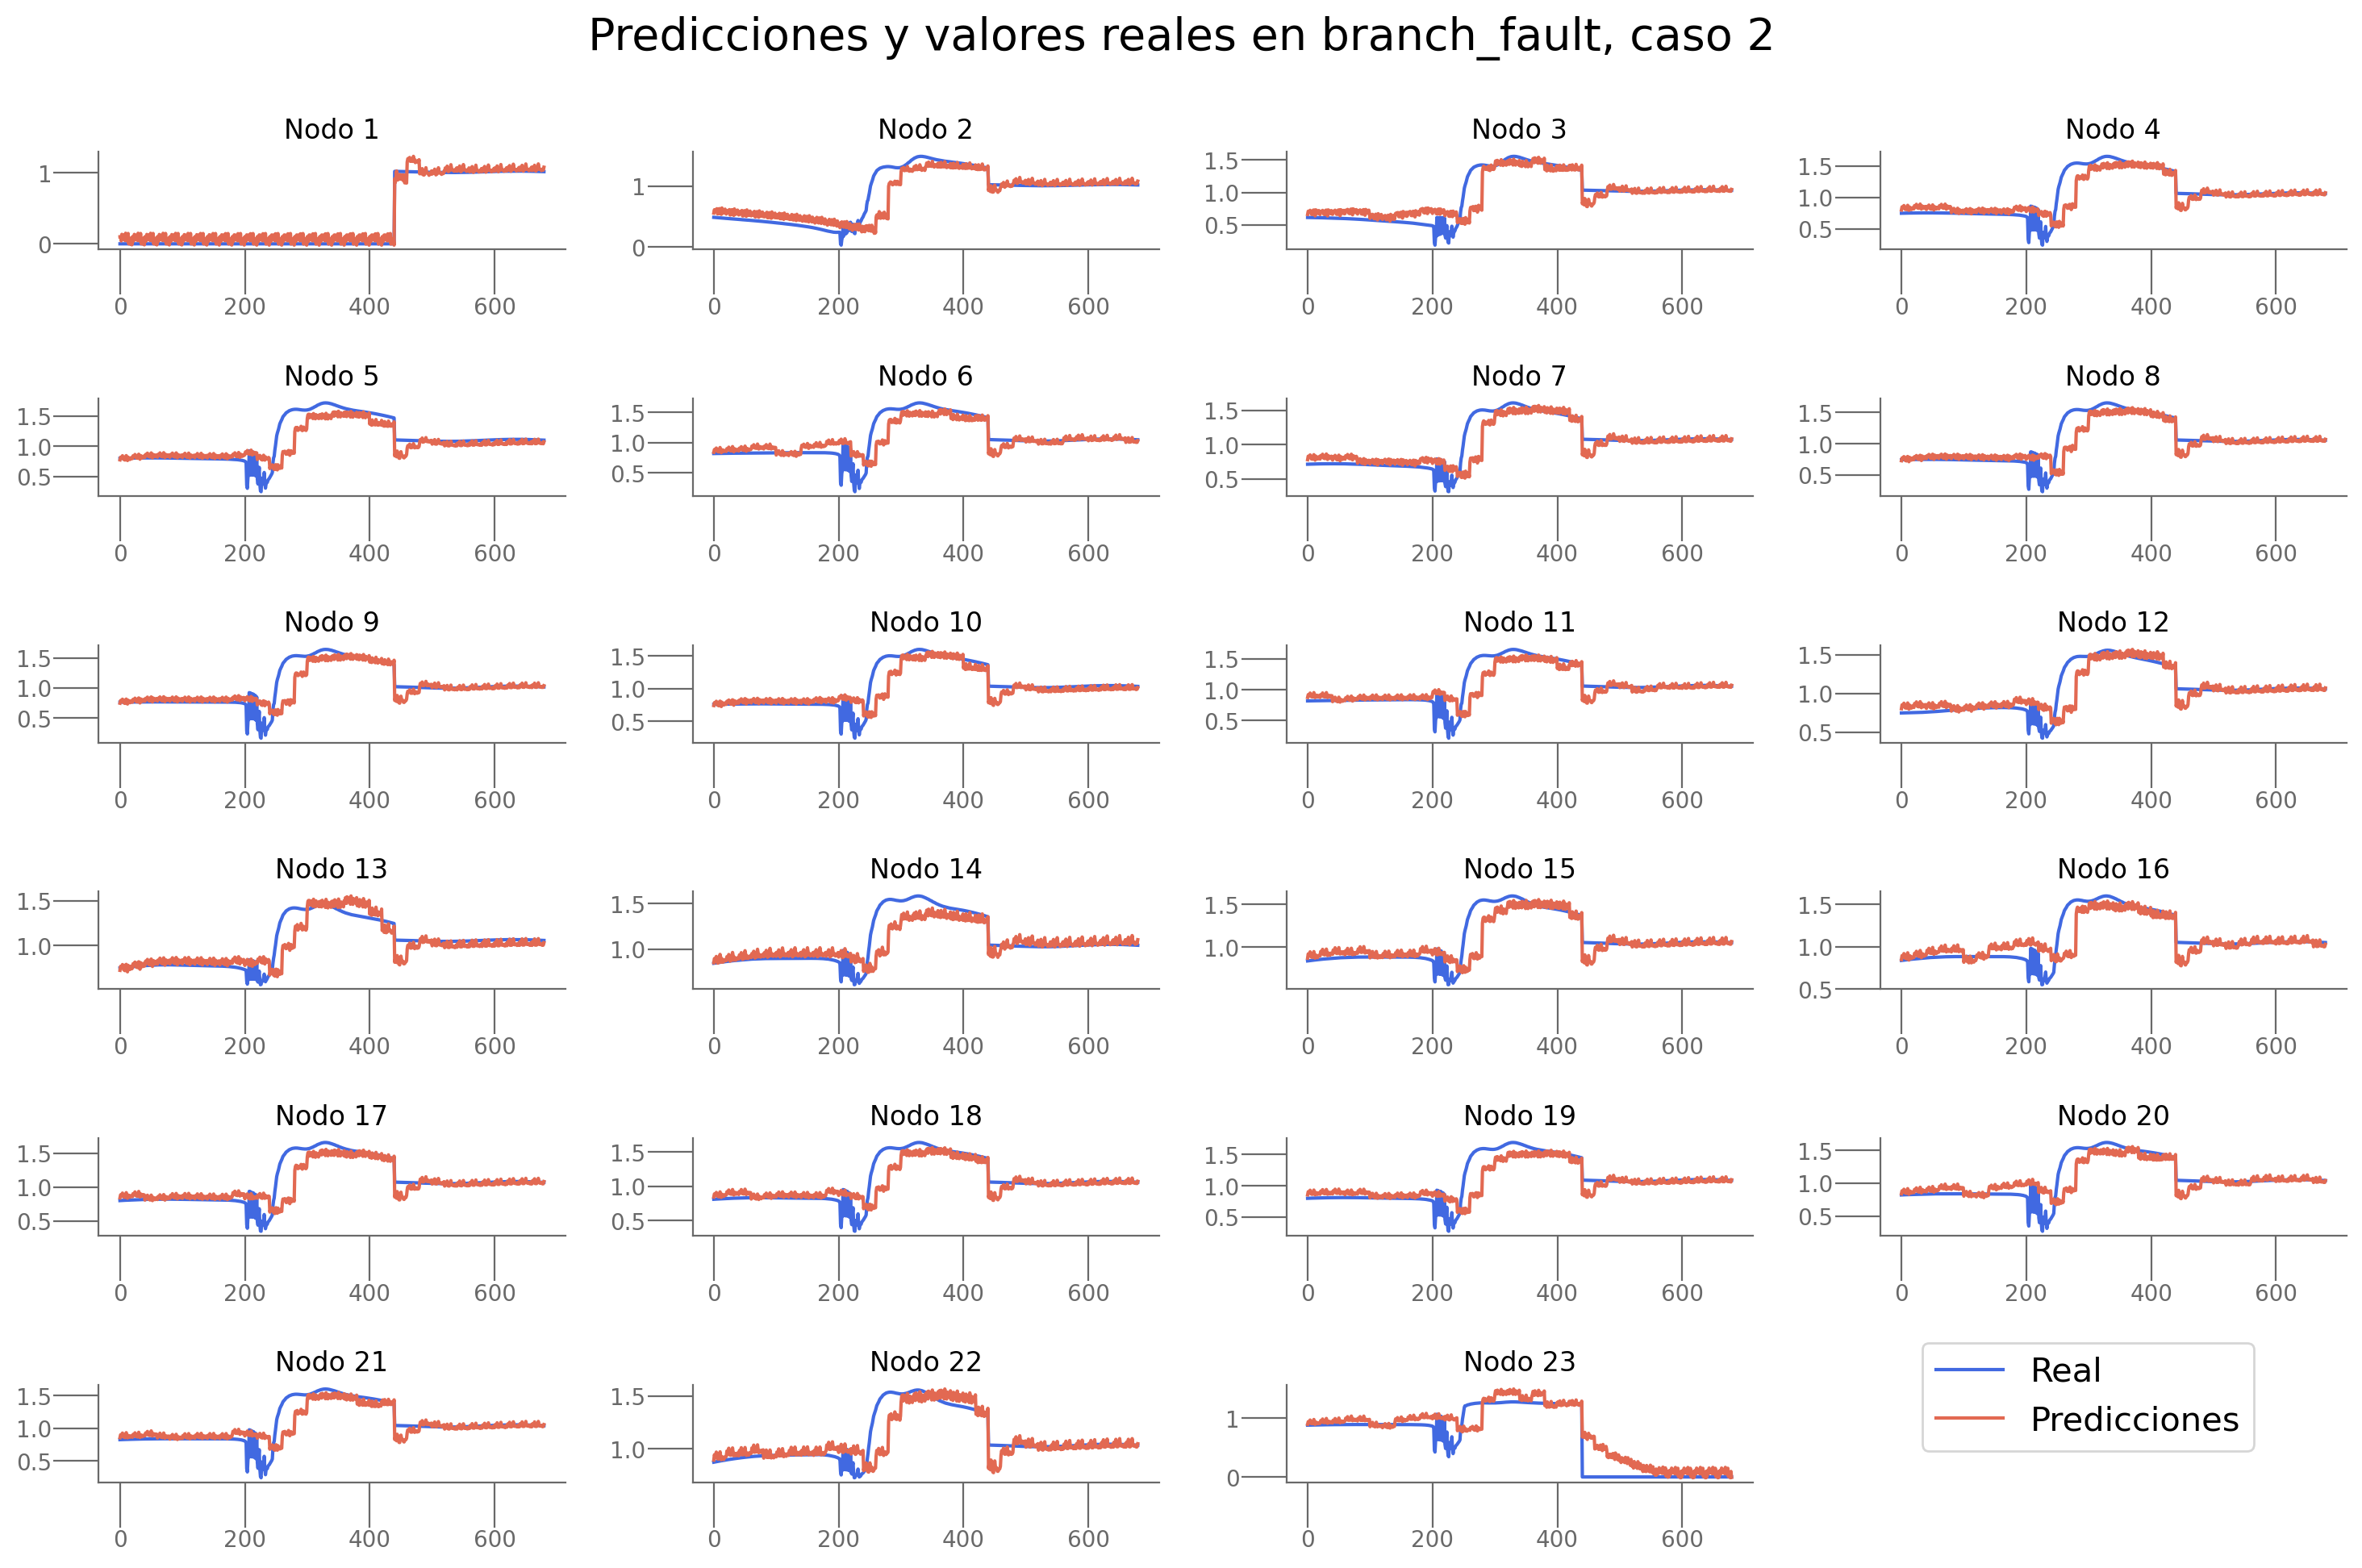

In [ ]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 2, n_div_brt, problem_brt)

In [ ]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [ ]:
guardar_resultados(modelo_brt, "DryGrEncoder", problem_brt, resultados_final_brt, results_save_path, path_save_experiment_brt, params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo       Params  \
0          LSTM          NaN   
1  DryGrEncoder  (add, 1, 2)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.019392  0.702621   
1  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.014330  0.506890   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00679742 0.00685346 0.01119131 0.02153048 0... -4.979866   0.237984   
1  [0.012768067419528961, 0.014942342415452003, 0...  0.537312   0.014044   

   Loss_final  
0    0.017030  
1    0.014403  

==================== RESULTADOS GUARDADOS ===================

